# <font color='red'>**Phân tích ảnh hưởng của chiến lược giảm giá đến doanh số trong thương mại điện tử bằng APACHE SPARK**</font>

## <font color='blue'>**Khởi tạo và kiểm tra dữ liệu**</font>

In [ ]:
!pip install --quiet pyspark matplotlib pandas
!pip install --quiet openpyxl

In [ ]:
# KHAI BÁO THƯ VIỆN
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình hiển thị cho pandas
pd.set_option('display.max_columns', None)

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, abs as spark_abs, mean

In [ ]:
# KHỞI TẠO SPARK
spark = SparkSession.builder \
    .appName("DiscountImpactAnalysis") \
    .master("local[*]") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark version:", spark.version)

Spark version: 4.0.1


In [ ]:
# Tải và xem dữ liệu
df = spark.read.csv('/content/synthetic_ecommerce_data.csv', header=True, inferSchema=True)
df.show(15)

+--------------------+--------------+-----------+----------------+----------+----------------+--------+------+-----------+---------------+---------------+-------------+------+------+--------+------+
|      Transaction_ID|   Customer_ID| Product_ID|Transaction_Date|Units_Sold|Discount_Applied| Revenue|Clicks|Impressions|Conversion_Rate|       Category|       Region|Ad_CTR|Ad_CPC|Ad_Spend| Price|
+--------------------+--------------+-----------+----------------+----------+----------------+--------+------+-----------+---------------+---------------+-------------+------+------+--------+------+
|4de9ff10-7243-4b2...| Customer_4529|Product_853|      2024-10-15|     189.0|            0.22|34648.12|  25.0|        313|           0.08|Home Appliances|North America|0.0839|  1.31|  109.91|235.03|
|aac57000-5e0e-42a...| Customer_9766|Product_863|      2024-11-06|     173.0|            0.19|35182.44|  17.0|        347|           0.05|Home Appliances|       Europe|0.1308|  1.25|   163.5|251.07|
|d814

## <font color='blue'>**Tiền xử lí dữ liệu**</font>

In [ ]:
# Kiểm tra các thông tin chung
print("Schema ban đầu:")
df.printSchema()

Schema ban đầu:
root
 |-- Transaction_ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Transaction_Date: date (nullable = true)
 |-- Units_Sold: double (nullable = true)
 |-- Discount_Applied: double (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: double (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- Conversion_Rate: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Ad_CTR: double (nullable = true)
 |-- Ad_CPC: double (nullable = true)
 |-- Ad_Spend: double (nullable = true)
 |-- Price: double (nullable = true)



* Tất cả các cột đều đúng kiểu định dạng
* Tuy nhiên hầu hết các cột đều nullable = true. Điều này báo hiệu rằng cần phải kiểm tra và xử lý các giá trị thiếu một cách cẩn thận trong quá trình tiền xử lý dữ liệu để đảm bảo chất lượng và tính toàn vẹn của phân tích.

In [ ]:
# Kiểm tra số dòng
num_rows = df.count()

# Kiểm tra số cột
num_cols = len(df.columns)

print("Số dòng:", num_rows)
print("Số cột:", num_cols)


Số dòng: 101500
Số cột: 16


### <font color='blue'>**Phân tích mô tả**</font>

In [ ]:
# TẠO BẢNG THỐNG KÊ MÔ TẢ

# Lọc ra danh sách các cột số từ schema hiện tại
numeric_cols = [field.name for field in df.schema.fields
                if isinstance(field.dataType, (IntegerType, DoubleType))]

# Xây dựng biểu thức tính toán
# Dùng percentile_approx để tính Q1, Median, Q3 hiệu quả trên Big Data
exprs = []
for col_name in numeric_cols:
    exprs.extend([
        F.min(col_name).alias(f"{col_name}_Min"),
        F.max(col_name).alias(f"{col_name}_Max"),
        F.mean(col_name).alias(f"{col_name}_Mean"),
        F.count(col_name).alias(f"{col_name}_Count"),
        F.variance(col_name).alias(f"{col_name}_Var"),
        F.stddev(col_name).alias(f"{col_name}_STD"),
        # 10000 là tham số độ chính xác (accuracy)
        F.percentile_approx(col_name, 0.25, 10000).alias(f"{col_name}_Q1"),
        F.percentile_approx(col_name, 0.50, 10000).alias(f"{col_name}_Q2"), # Q2 chính là Median
        F.percentile_approx(col_name, 0.75, 10000).alias(f"{col_name}_Q3")
    ])

# Thực thi tính toán
# .collect() trả về list, lấy phần tử [0] là Row chứa tất cả kết quả
print("Đang tính toán các chỉ số thống kê... (Bước này có thể mất vài giây)")
stats_row = df.select(exprs).collect()[0]

# Chuyển đổi kết quả sang Pandas DataFrame để hiển thị đẹp & Tính IQR
stats_data = []
for col_name in numeric_cols:
    # Lấy giá trị từ Row kết quả
    q1 = stats_row[f"{col_name}_Q1"]
    q3 = stats_row[f"{col_name}_Q3"]

    # Tính IQR
    iqr = (q3 - q1) if (q1 is not None and q3 is not None) else None

    stats_data.append({
        'Feature': col_name,
        'Min': stats_row[f"{col_name}_Min"],
        'Max': stats_row[f"{col_name}_Max"],
        'Mean': stats_row[f"{col_name}_Mean"],
        'Median': stats_row[f"{col_name}_Q2"],
        'Count': stats_row[f"{col_name}_Count"],
        'Var': stats_row[f"{col_name}_Var"],
        'STD': stats_row[f"{col_name}_STD"],
        'Q1': q1,
        'Q2': stats_row[f"{col_name}_Q2"],
        'Q3': q3,
        'IQR': iqr
    })

# Tạo DataFrame Pandas
df_desc = pd.DataFrame(stats_data)

# Sắp xếp cột theo đúng thứ tự
final_cols = ['Feature', 'Min', 'Max', 'Mean', 'Median', 'Count', 'Var', 'STD', 'Q1', 'Q2', 'Q3', 'IQR']
df_desc = df_desc[final_cols]

# Hiển thị
print(" BẢNG THỐNG KÊ MÔ TẢ ")
display(df_desc)

Đang tính toán các chỉ số thống kê... (Bước này có thể mất vài giây)
 BẢNG THỐNG KÊ MÔ TẢ 


,Feature,Min,Max,Mean,Median,Count,Var,STD,Q1,Q2,Q3,IQR
0,Units_Sold,51.00,716.00,128.340172,127.0000,98462,2.466245e+03,49.661304,84.0000,127.0000,166.0000,82.0000
1,Discount_Applied,0.00,0.30,0.149901,0.1500,101500,7.517419e-03,0.086703,0.0700,0.1500,0.2200,0.1500
2,Revenue,443.21,386945.04,20310.670438,4754.4700,98462,7.791533e+08,27913.317761,2154.1500,4754.4700,31517.4900,29363.3400
3,Clicks,0.00,49.00,24.536862,25.0000,98448,2.073847e+02,14.400859,12.0000,25.0000,37.0000,25.0000
4,Impressions,10.00,499.00,254.530700,254.0000,101500,2.001289e+04,141.466926,132.0000,254.0000,377.0000,245.0000
5,Conversion_Rate,0.00,4.90,0.198475,0.1000,98449,1.307748e-01,0.361628,0.0500,0.1000,0.1900,0.1400
6,Ad_CTR,0.01,0.20,0.105012,0.1052,101500,3.003491e-03,0.054804,0.0575,0.1052,0.1522,0.0947
7,Ad_CPC,0.10,2.00,1.051508,1.0500,101500,3.016050e-01,0.549186,0.5800,1.0500,1.5300,0.9500
8,Ad_Spend,1.05,399.60,110.566576,87.3200,101500,7.578993e+03,87.057413,38.6300,87.3200,164.4200,125.7900
9,Price,12.00,659.99,178.791153,44.1100,101500,4.454971e+04,211.068030,22.0900,44.1100,278.0800,255.9900


In [ ]:
# Xuất kết quả thống kê ra file Excel
output_file = "Thong_ke_mo_ta_chi_tiet.xlsx"
df_desc.to_excel(output_file, index=False)

Dựa trên bảng thống kê mô tả, dưới đây là các nhận định quan trọng về đặc điểm phân phối của bộ dữ liệu:

**1. Phân phối Đơn hàng (Units Sold) - Ổn định**

  * **Tương đồng Mean - Median:** Trung bình (`Mean` $\approx$ 128) và Trung vị (`Median` = 127) gần như trùng khớp. Điều này cho thấy số lượng sản phẩm bán ra trong mỗi đơn hàng tuân theo phân phối chuẩn, tập trung chủ yếu quanh mức 127 sản phẩm.
  * **Biến động:** Độ lệch chuẩn (`STD` $\approx$ 50) ở mức vừa phải so với trung bình, cho thấy sức mua khá ổn định, ít có các đơn hàng đột biến bất thường (ngoại trừ giá trị Max 716 có thể là đơn sỉ).

**2. Biến động Doanh thu (Revenue) - Phân hóa Cực mạnh**

  * **Sự chênh lệch khổng lồ:** `Mean` (20,310 USD) lớn gấp 4 lần `Median` (4,754 USD).
      * *Nguyên nhân:* Đây là dấu hiệu của sự phân hóa sâu sắc do **đặc thù ngành hàng**. Nhóm hàng giá trị cao (như Electronics, giá trung bình \> 500$) tạo ra các đơn hàng doanh thu khủng (lên tới Max = 386,945 USD), kéo mức trung bình lên rất cao so với phần đông các đơn hàng giá trị thấp (như Sách, Đồ chơi).
  * **Độ rủi ro cao:** `STD` (27,913 USD) lớn hơn cả giá trị trung bình. Dữ liệu doanh thu có độ phân tán cực rộng, đòi hỏi mô hình dự báo phải có khả năng xử lý tốt các biến động này (hoặc cần chuẩn hóa dữ liệu đầu vào).

**3. Cấu trúc Giá (Price) - Phản ánh đúng thực tế**

  * **Phân phối:** Giá sản phẩm trải rộng từ 12 USD đến \~660 USD.
  * **Sự tập trung:** Mặc dù giá trung bình là \~179 USD, nhưng 50% số sản phẩm (`Median`) có giá dưới 44 USD.

Cho thấy doanh nghiệp bán số lượng lớn các mặt hàng giá rẻ (Books, Toys, Clothing) nhưng doanh thu chủ lực lại đến từ nhóm thiểu số các mặt hàng giá cao (Electronics).

**4. Vấn đề Dữ liệu (Cần xử lý)**

  * **Dữ liệu thiếu:**
      * Tổng số dòng: **101,500**.
      * Số dòng hợp lệ của `Units_Sold`, `Revenue`, `Clicks`, `Conversion_Rate`: Chỉ khoảng **98,448 - 98,462**.
      * $\Rightarrow$ Có khoảng **3,000 giao dịch (chiếm \~3%)** bị khuyết thông tin. Đây là tỷ lệ nhỏ nhưng bắt buộc phải xử lý để không làm nhiễu mô hình.
  * **Chiến lược Giảm giá & Marketing:**
      * Giảm giá (`Discount`) được áp dụng rất đều đặn (Mean $\approx$ Median $\approx$ 15%), cho thấy đây là chính sách thường xuyên chứ không phải thời vụ.
      * Chi phí quảng cáo (`Ad_Spend`) biến động mạnh (Max gấp 4.5 lần Median), cần xem xét hiệu quả của các chiến dịch chi tiêu lớn này.

**Kết luận:** Bộ dữ liệu đủ chất lượng để phân tích, nhưng cần xử lý missing Values và outliers để đảm bảo độ chính xác cho các mô hình dự báo.

### <font color='blue'>**Kiểm tra và xử lí giá trị khuyết thiếu**</font>

In [ ]:
# Tính tổng số dòng
num_rows = df.count()

# Tạo bảng thống kê null
missing_stats = (
    df.select([
        F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns
    ])
    .toPandas()
    .transpose()
)

# Đặt tên cột và tính phần trăm
missing_stats.columns = ["Missing_Count"]
missing_stats["Missing_%"] = (missing_stats["Missing_Count"] / num_rows) * 100

# Sắp xếp giảm dần để dễ nhìn và hiển thị
missing_stats = missing_stats.sort_values(by="Missing_Count", ascending=False)
print(missing_stats)

                  Missing_Count  Missing_%
Category                   3054   3.008867
Clicks                     3052   3.006897
Conversion_Rate            3051   3.005911
Region                     3047   3.001970
Revenue                    3038   2.993103
Units_Sold                 3038   2.993103
Transaction_Date              0   0.000000
Transaction_ID                0   0.000000
Discount_Applied              0   0.000000
Customer_ID                   0   0.000000
Product_ID                    0   0.000000
Impressions                   0   0.000000
Ad_CTR                        0   0.000000
Ad_CPC                        0   0.000000
Ad_Spend                      0   0.000000
Price                         0   0.000000


Trong bộ dữ liệu, các trường quan trọng (`Units_Sold`, `Revenue`, `Category`) và các trường phụ trợ (`Clicks`, `Conversion_Rate`) có tỷ lệ dữ liệu trống khoảng **3%** (tương đương ~3,000 quan sát). Nhóm nghiên cứu áp dụng chiến lược xử lý linh hoạt như sau:

1.  **Đối với các biến cốt lõi (`Revenue`, `Units_Sold`, `Category`): Quyết định loại bỏ**.
    * **Lý do:** `Revenue` là biến mục tiêu của mô hình, còn `Category` là biến đại diện cho mức giá sản phẩm. Việc điền khuyết bằng trung bình/trung vị vào các biến này sẽ phá vỡ mối quan hệ kinh tế tự nhiên và làm sai lệch kết quả dự báo.
    * Việc loại bỏ 3% dữ liệu không ảnh hưởng đáng kể đến độ tin cậy thống kê do kích thước mẫu còn lại vẫn rất lớn.

2.  **Đối với các biến Marketing phụ trợ (`Clicks`, `Conversion_Rate`): Quyết định điền khuyết**.
    * Sau khi loại bỏ các dòng thiếu biến cốt lõi, các giá trị thiếu còn lại ở biến phụ được xử lý để tối ưu hóa dữ liệu:
    * **`Clicks`:** Điền bằng **Trung vị (Median)** để tránh ảnh hưởng của các giá trị ngoại lai.
    * **`Conversion_Rate`:** Điền bằng **Trung bình (Mean)** vì đây là tỷ lệ thường có phân phối ổn định.

In [ ]:
# XỬ LÝ DỮ LIỆU THIẾU

print(f"Số dòng trước khi xử lý: {df.count()}")

# Xóa các dòng bị thiếu thông tin quan trọng
cols_essential = ["Revenue", "Units_Sold", "Category", "Region"]
df_clean = df.na.drop(subset=cols_essential)

# Gán ngược lại cho df chính để dùng cho các bước sau
df = df_clean

print(f"Số dòng sau khi xử lý: {df.count()}")

Số dòng trước khi xử lý: 101500
Số dòng sau khi xử lý: 92642


In [ ]:
# XỬ LÝ NỐT CÁC CỘT PHỤ (Clicks, Conversion_Rate)
# Xử lý Clicks: Điền bằng Trung vị (Median)
clicks_median = int(df.approxQuantile("Clicks", [0.5], 0.01)[0])
df = df.fillna({"Clicks": clicks_median})

# Xử lý Conversion_Rate: Điền bằng Trung bình (Mean)
conv_mean = df.select(F.mean("Conversion_Rate")).collect()[0][0]
df = df.fillna({"Conversion_Rate": conv_mean})

print(f"-> Đã điền Clicks bằng: {clicks_median}")
print(f"-> Đã điền Conversion_Rate bằng: {conv_mean:.4f}")

-> Đã điền Clicks bằng: 25
-> Đã điền Conversion_Rate bằng: 0.1985


In [ ]:
# Kiểm tra xem còn giá trị Null nào sót lại không
print("\nKiểm tra lại số lượng Null còn sót lại:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Kiểm tra lại số lượng Null còn sót lại:
+--------------+-----------+----------+----------------+----------+----------------+-------+------+-----------+---------------+--------+------+------+------+--------+-----+
|Transaction_ID|Customer_ID|Product_ID|Transaction_Date|Units_Sold|Discount_Applied|Revenue|Clicks|Impressions|Conversion_Rate|Category|Region|Ad_CTR|Ad_CPC|Ad_Spend|Price|
+--------------+-----------+----------+----------------+----------+----------------+-------+------+-----------+---------------+--------+------+------+------+--------+-----+
|             0|          0|         0|               0|         0|               0|      0|     0|          0|              0|       0|     0|     0|     0|       0|    0|
+--------------+-----------+----------+----------------+----------+----------------+-------+------+-----------+---------------+--------+------+------+------+--------+-----+



Sau khi xử lí, toàn bộ dữ liệu đã không còn giá trị khuyết thiếu.

### <font color='blue'>**Kiểm tra và xử lí giá trị trùng lặp**</font>

In [ ]:
# Đếm số dòng trùng lặp
duplicate_count = df.count() - df.dropDuplicates().count()

print("Số lượng dòng trùng lặp:", duplicate_count)

Số lượng dòng trùng lặp: 0


Kiểm tra giá trị trùng lặp cho thấy không tồn tại các bản ghi trùng lặp. Dữ liệu đã sẵn sàng cho các bước xử lý tiếp theo.

### <font color='blue'>**Kiểm tra và xử lí giá trị ngoại lai**</font>

In [ ]:
# KIỂM TRA NGOẠI LAI TOÀN BỘ CÁC CỘT SỐ

# Lấy danh sách tất cả các cột số (trừ các cột ID, Ngày tháng đã biết)
# Loại bỏ Transaction_Month, Is_Weekend vì đó là biến phân loại dạng số
exclude_cols = ["Transaction_Month", "Is_Weekend", "Day_Of_Week", "Year"]
numeric_cols = [field.name for field in df.schema.fields
                if isinstance(field.dataType, (IntegerType, DoubleType))
                and field.name not in exclude_cols]

print(f"Đang kiểm tra ngoại lai cho {len(numeric_cols)} cột: {numeric_cols}")
print("-" * 60)

# Vòng lặp tính toán thống kê (IQR)
outlier_stats = []

for col_name in numeric_cols:
    # Tính Q1, Q3
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1

    # Xác định biên
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    # Đếm số lượng ngoại lai
    outlier_count = df.filter((F.col(col_name) < lower_fence) | (F.col(col_name) > upper_fence)).count()
    total_count = df.count()
    percent = (outlier_count / total_count) * 100

    outlier_stats.append({
        'Column': col_name,
        'Outliers': outlier_count,
        '%': round(percent, 2),
        'Lower_Fence': round(lower_fence, 2),
        'Upper_Fence': round(upper_fence, 2)
    })

    print(f" {col_name}: {outlier_count} ngoại lai ({percent:.2f}%) | Ngưỡng trên: {upper_fence:.2f}")



Đang kiểm tra ngoại lai cho 10 cột: ['Units_Sold', 'Discount_Applied', 'Revenue', 'Clicks', 'Impressions', 'Conversion_Rate', 'Ad_CTR', 'Ad_CPC', 'Ad_Spend', 'Price']
------------------------------------------------------------
 Units_Sold: 162 ngoại lai (0.17%) | Ngưỡng trên: 288.00
 Discount_Applied: 0 ngoại lai (0.00%) | Ngưỡng trên: 0.44
 Revenue: 6943 ngoại lai (7.49%) | Ngưỡng trên: 75342.00
 Clicks: 0 ngoại lai (0.00%) | Ngưỡng trên: 72.00
 Impressions: 0 ngoại lai (0.00%) | Ngưỡng trên: 738.50
 Conversion_Rate: 8957 ngoại lai (9.67%) | Ngưỡng trên: 0.42
 Ad_CTR: 0 ngoại lai (0.00%) | Ngưỡng trên: 0.29
 Ad_CPC: 0 ngoại lai (0.00%) | Ngưỡng trên: 2.95
 Ad_Spend: 1004 ngoại lai (1.08%) | Ngưỡng trên: 345.42
 Price: 79 ngoại lai (0.09%) | Ngưỡng trên: 659.18


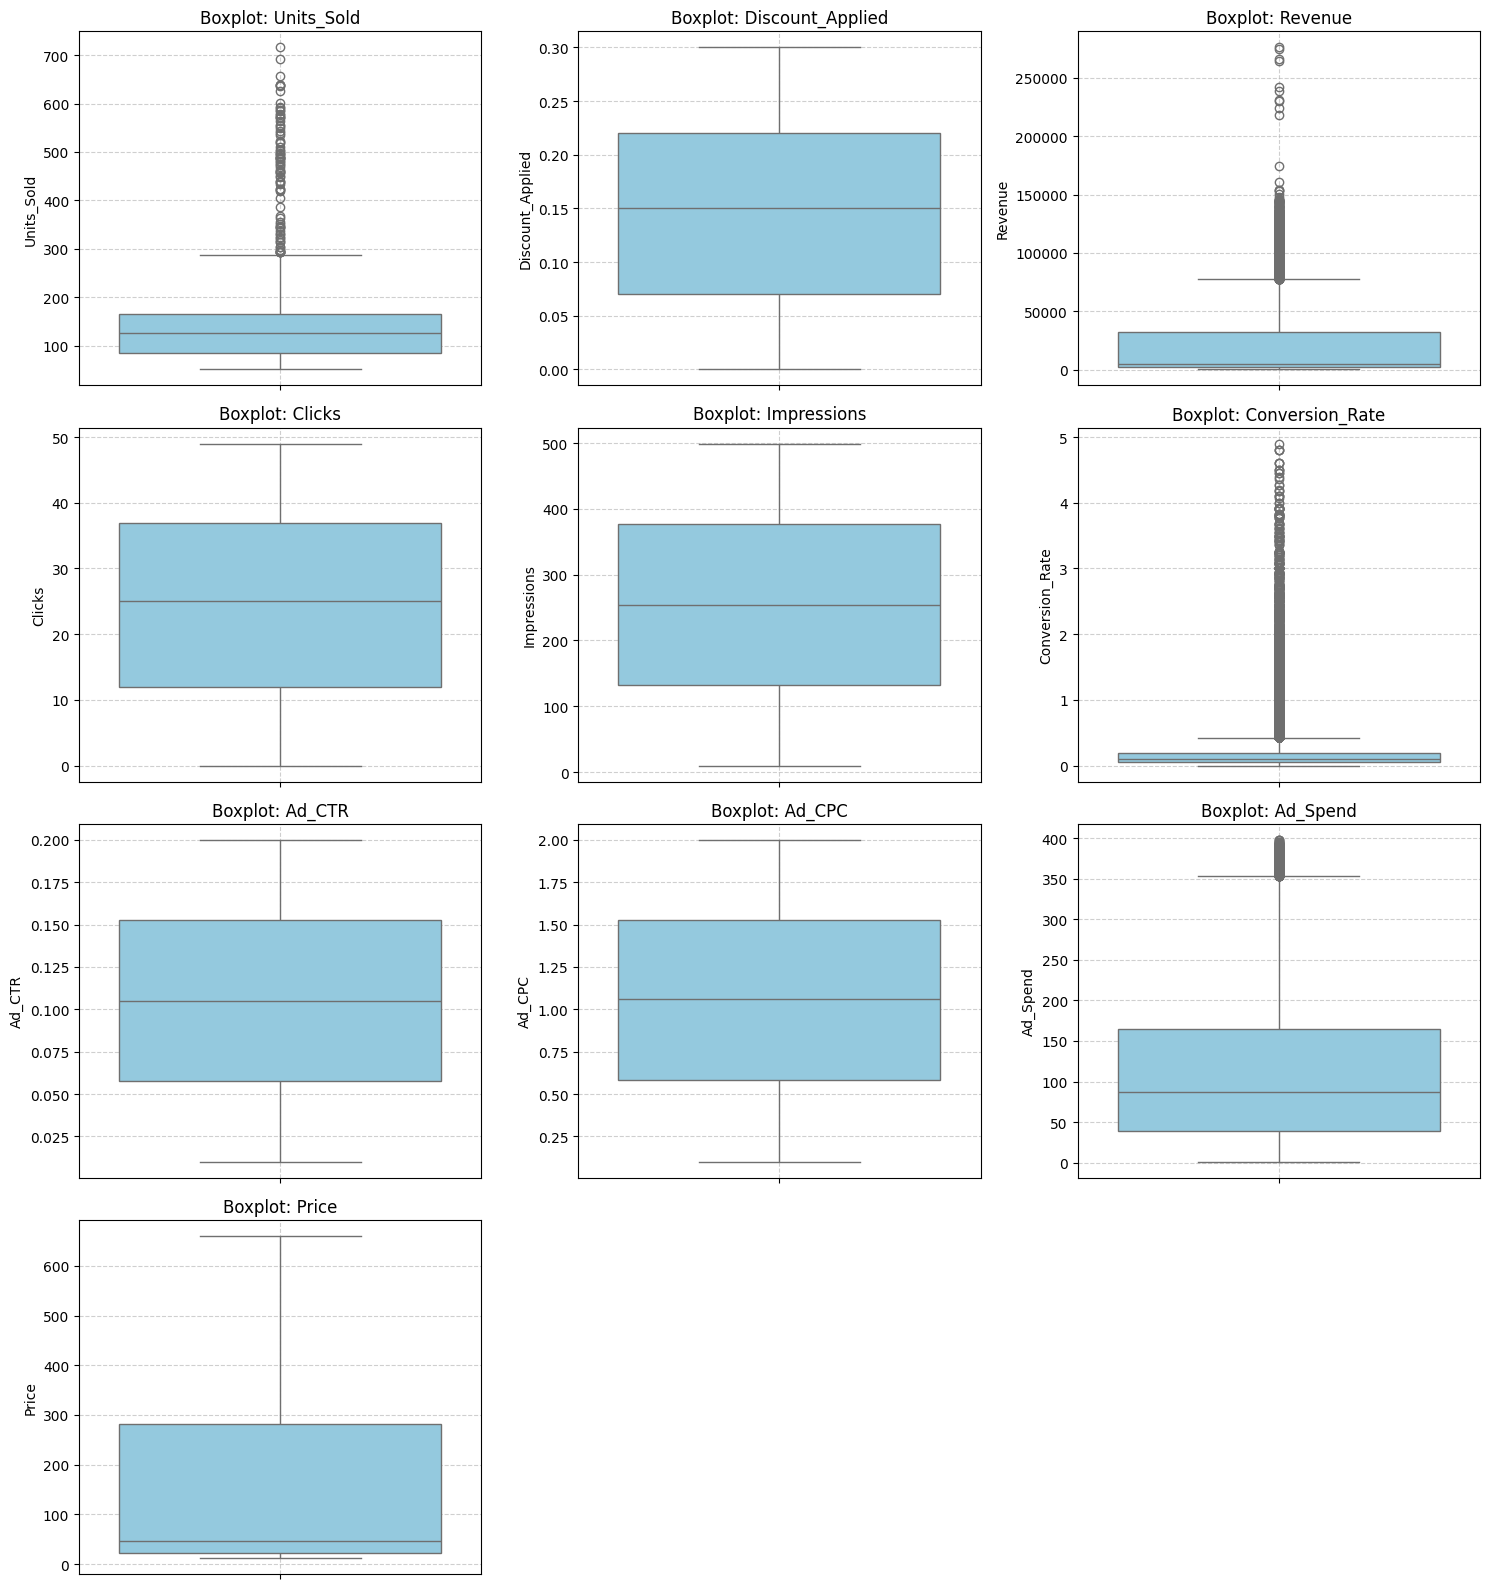

In [ ]:
# Vẽ Boxplot cho tất cả các cột

# Lấy mẫu ngẫu nhiên 50% để vẽ cho nhẹ (tùy chỉnh fraction=1.0 nếu muốn lấy hết)
pdf_plot = df.sample(fraction=0.5, seed=42).select(numeric_cols).toPandas()

# Thiết lập lưới biểu đồ tự động
num_plots = len(numeric_cols)
cols_per_row = 3
rows = (num_plots // cols_per_row) + (1 if num_plots % cols_per_row > 0 else 0)

plt.figure(figsize=(15, rows * 4))

for i, col_name in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.boxplot(y=pdf_plot[col_name], color='skyblue')
    plt.title(f'Boxplot: {col_name}')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Dựa trên kết quả phân tích phân phối dữ liệu, nhóm nghiên cứu áp dụng chiến lược phân loại để xử lý ngoại lai nhằm tối ưu hóa độ chính xác của mô hình:

1.  **Nhóm Biến Mục tiêu `Revenue`**

      * **Quan sát:** Tỷ lệ ngoại lai \~7.5%, chủ yếu là các giá trị cực lớn.
      * **Quyết định:** Không can thiệp xử lý.
      * **Lý do:** Các giá trị này phản ánh đúng bản chất phân hóa của ngành hàng (giá trị đơn hàng Điện tử cao gấp nhiều lần Sách). Việc giữ nguyên giúp mô hình học được đầy đủ biên độ dao động của doanh thu thực tế.

2.  **Nhóm Biến Độc lập Định lượng (`Units_Sold`, `Ad_Spend`) - chiến lược: CAPPING (IQR)**

      * **Quan sát:** Tỷ lệ ngoại lai thấp (\< 2%).
      * **Quyết định:** Thay thế các giá trị vượt quá ngưỡng trên bằng chính giá trị ngưỡng trên.
      * **Mục đích:** Giảm thiểu nhiễu từ các đơn hàng sỉ hoặc các chiến dịch quảng cáo chi tiêu bất thường, giúp mô hình hồi quy ổn định hơn.

3.  **Nhóm Biến Tỷ lệ (`Conversion_Rate`) - chiến lược: WINSORIZING (1% - 99%)**

      * **Quan sát:** Tỷ lệ ngoại lai rất cao (\> 9%) với độ biến động lớn (Max lên tới 4.9 tức 490%).
      * **Quyết định:** Giới hạn giá trị trong khoảng phân vị từ 1% đến 99% (ngưỡng trên khoảng **1.94**).
      * **Mục đích:** Loại bỏ các tỷ lệ chuyển đổi ảo mà vẫn giữ được cấu trúc phân phối tự nhiên.

In [ ]:
from pyspark.sql.functions import col, when, lit
import pyspark.sql.functions as F
# CHIẾN LƯỢC CAPPING (IQR)
# Áp dụng cho: Units_Sold, Ad_Spend
capping_cols = ["Units_Sold", "Ad_Spend"]
for col_name in capping_cols:
    # Tính toán Q1, Q3
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]

    # Tính IQR và Ngưỡng trên
    iqr = q3 - q1
    upper_fence = q3 + 1.5 * iqr

    # Thực hiện Capping
    df = df.withColumn(col_name,
                       when(col(col_name) > upper_fence, upper_fence)
                       .otherwise(col(col_name)))

    print(f"-> Đã xử lý cột '{col_name}':")
    print(f"   + Q3: {q3} | IQR: {iqr}")
    print(f"   + Capping tại ngưỡng trên: {upper_fence:.2f}")

# CHIẾN LƯỢC WINSORIZING (1% - 99%)
# Áp dụng cho: Conversion_Rate
winsor_col = "Conversion_Rate"
# Tính phân vị thứ 1 (1%) và 99 (99%)
quantiles_conv = df.approxQuantile(winsor_col, [0.01, 0.99], 0.001)
lower_bound, upper_bound = quantiles_conv[0], quantiles_conv[1]

# Thực hiện kẹp giá trị
df = df.withColumn(winsor_col,
                   when(col(winsor_col) < lower_bound, lower_bound)
                   .when(col(winsor_col) > upper_bound, upper_bound)
                   .otherwise(col(winsor_col)))

print(f"-> Đã giới hạn '{winsor_col}' trong khoảng [{lower_bound:.4f}, {upper_bound:.4f}]")
# Kiểm tra lại kết quả
df.select(
    F.max("Units_Sold").alias("Max_Units (Đã Capping)"),
    F.max("Ad_Spend").alias("Max_AdSpend (Đã Capping)"),
    F.max("Conversion_Rate").alias("Max_ConvRate (Đã Winzor)"),
    F.max("Revenue").alias("Max_Revenue (GIỮ NGUYÊN)")
).show()

-> Đã xử lý cột 'Units_Sold':
   + Q3: 165.0 | IQR: 82.0
   + Capping tại ngưỡng trên: 288.00
-> Đã xử lý cột 'Ad_Spend':
   + Q3: 160.92 | IQR: 122.99999999999999
   + Capping tại ngưỡng trên: 345.42
-> Đã giới hạn 'Conversion_Rate' trong khoảng [0.0000, 1.8200]
+----------------------+------------------------+------------------------+------------------------+
|Max_Units (Đã Capping)|Max_AdSpend (Đã Capping)|Max_ConvRate (Đã Winzor)|Max_Revenue (GIỮ NGUYÊN)|
+----------------------+------------------------+------------------------+------------------------+
|                 288.0|      345.41999999999996|                    1.82|               386945.04|
+----------------------+------------------------+------------------------+------------------------+



Dữ liệu đã sạch, phân phối chuẩn hơn.

### <font color='blue'>**Kiểm tra và xử lí giá trị không hợp lệ**</font>

In [ ]:
#Kiểm tra giá trị không hợp lệ (Conversion_Rate < 0 hoặc > 1)
df.filter((F.col("Conversion_Rate") < 0) | (F.col("Conversion_Rate") > 1)).count()

2865

-> Nhận xét: Điều chỉnh giá trị sai của Conversion_Rate: Trong quá trình kiểm tra, phát hiện 2865 giá trị của cột Conversion_Rate nằm ngoài khoảng hợp lệ [0,1]. Những giá trị này được sửa về phạm vi hợp lệ bằng cách cắt trần và cắt sàn, đảm bảo tất cả các giá trị đều nằm trong khoảng từ 0 đến 1, phản ánh đúng tỷ lệ chuyển đổi thực tế

In [ ]:
#Điều chỉnh giá trị sai của Conversion_Rate
df = df.withColumn(
    "Conversion_Rate",
    F.when(F.col("Conversion_Rate") < 0, 0)
     .when(F.col("Conversion_Rate") > 1, 1)
     .otherwise(F.col("Conversion_Rate"))
)

In [ ]:
#Kiểm tra lại sau khi xử lí
df.filter((F.col("Conversion_Rate") < 0) | (F.col("Conversion_Rate") > 1)).count()

0

##<font color='blue'>**Phân tích khám phá (EDA)**</font>

In [ ]:
# CHUẨN BỊ DỮ LIỆU CHO EDA
# Chuyển đổi các cột số quan trọng sang Pandas để vẽ
pdf_dist = df.select("Units_Sold", "Revenue", "Ad_Spend", "Conversion_Rate", "Discount_Applied").toPandas()

print("Đã chuyển đổi dữ liệu sang Pandas để sẵn sàng trực quan hóa.")

Đã chuyển đổi dữ liệu sang Pandas để sẵn sàng trực quan hóa.


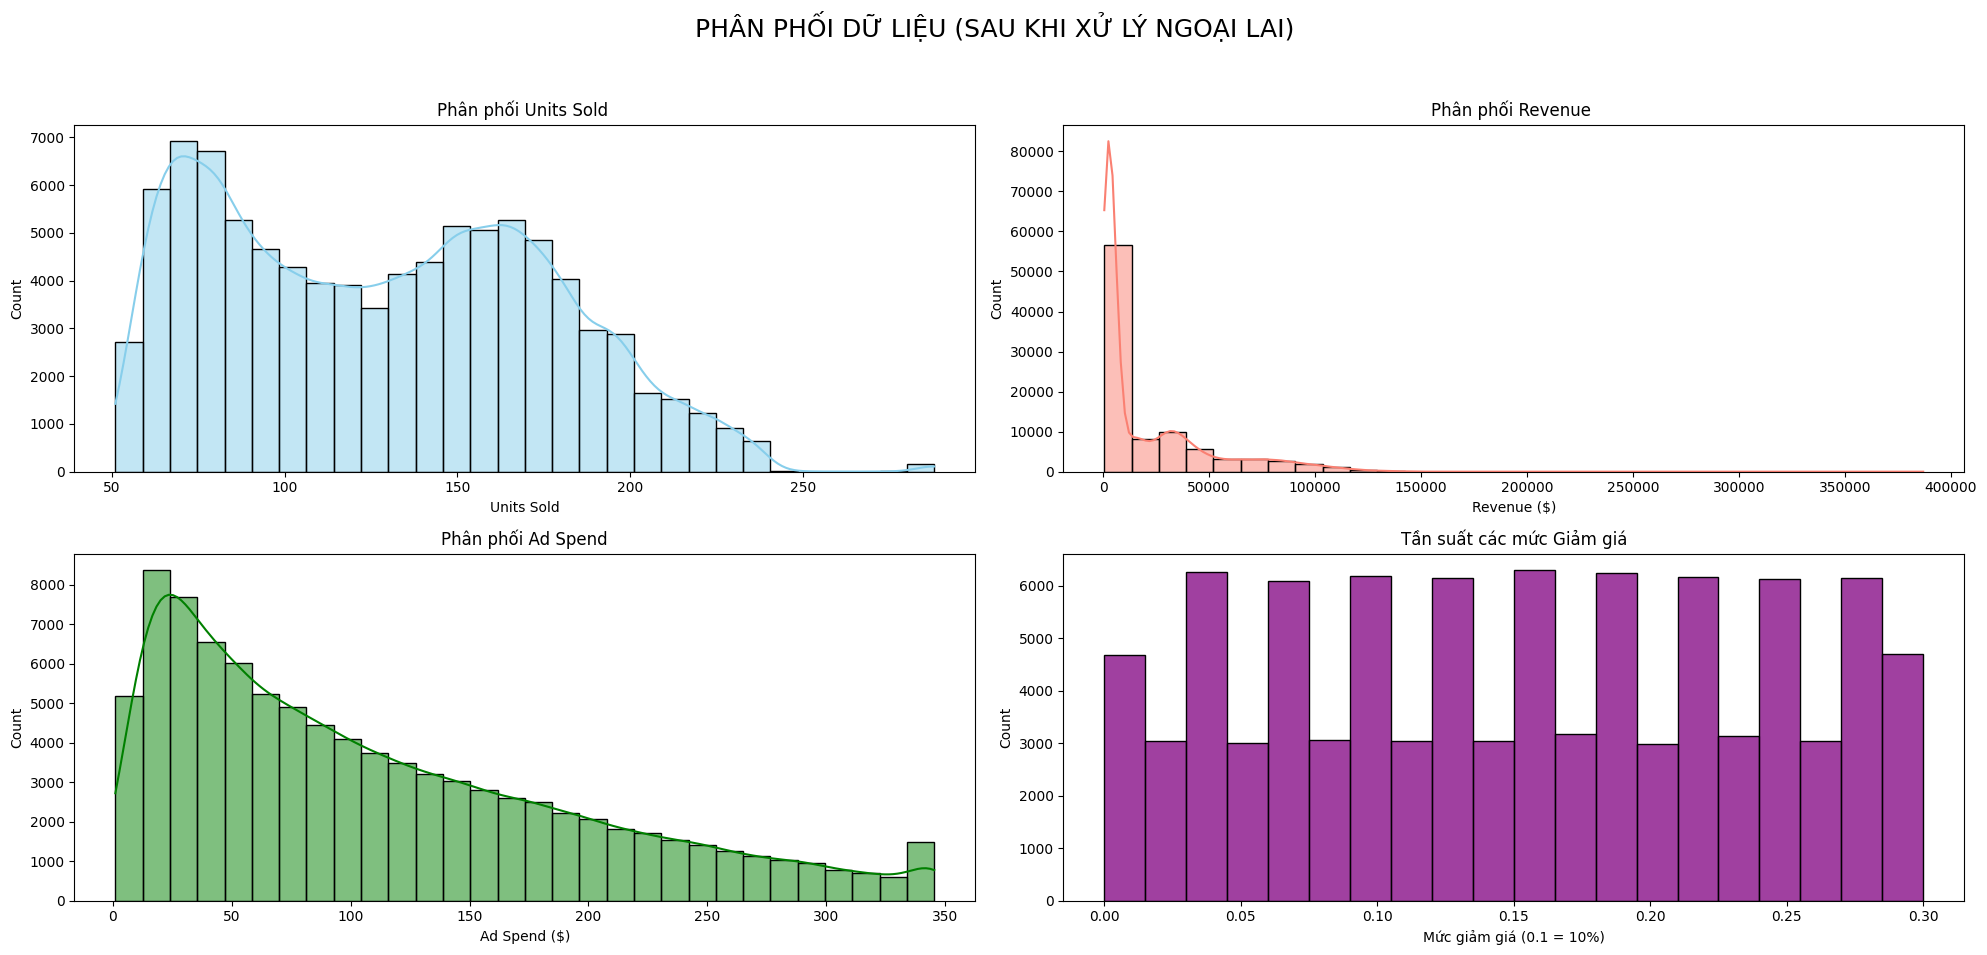

In [ ]:
# Thiết lập kích thước khung hình
plt.figure(figsize=(20, 10))
plt.suptitle('PHÂN PHỐI DỮ LIỆU (SAU KHI XỬ LÝ NGOẠI LAI)', fontsize=18)

# Phân phối Số lượng bán (Units Sold)
plt.subplot(2, 2, 1)
sns.histplot(pdf_dist['Units_Sold'], bins=30, kde=True, color='skyblue')
plt.title('Phân phối Units Sold ')
plt.xlabel('Units Sold')

# Phân phối Doanh thu (Revenue)
plt.subplot(2, 2, 2)
sns.histplot(pdf_dist['Revenue'], bins=30, kde=True, color='salmon')
plt.title('Phân phối Revenue ')
plt.xlabel('Revenue ($)')

# Phân phối Chi phí Quảng cáo (Ad Spend)
plt.subplot(2, 2, 3)
sns.histplot(pdf_dist['Ad_Spend'], bins=30, kde=True, color='green')
plt.title('Phân phối Ad Spend')
plt.xlabel('Ad Spend ($)')

# 4. Phân phối Mức giảm giá (Discount Applied)
plt.subplot(2, 2, 4)
sns.histplot(pdf_dist['Discount_Applied'], bins=20, kde=False, color='purple')
plt.title('Tần suất các mức Giảm giá')
plt.xlabel('Mức giảm giá (0.1 = 10%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Sau khi trực quan hóa phân phối của các biến số chính, chúng ta rút ra các kết luận quan trọng về đặc điểm dữ liệu sau xử lý:

**1. Phân phối Doanh thu (Revenue) - Tính chất "Đuôi dài" (Long-tail)**
* **Hình dáng:** Dữ liệu thể hiện phân phối **lệch phải (Right-skewed)** rất mạnh. Đa số các giao dịch có giá trị nhỏ (tập trung bên trái), nhưng tồn tại phần "đuôi" kéo dài tới các giá trị rất lớn (lên tới ~380,000 USD).
* **Ý nghĩa:**
    * Điều này phản ánh trung thực bản chất của mô hình kinh doanh đa ngành hàng: Doanh thu từ các sản phẩm giá trị cao (Electronics) tuy số lượng ít nhưng giá trị vượt trội so với các sản phẩm phổ thông (Books, Toys).
    * **Lưu ý:** Biến này không bị áp dụng Capping để đảm bảo mô hình học được chính xác các giao dịch giá trị cao.

**2. Phân phối Sản Lượng & Chi Phí QC (`Units_Sold` & `Ad_Spend`)**
* Biểu đồ xuất hiện sự "đứt gãy" đột ngột tại ngưỡng trần (Units ~ 288, Ad_Spend ~ 345).
* Đây là minh chứng trực quan cho kỹ thuật xử lý ngoại lai bằng IQR. Các giá trị cực đoan gây nhiễu đã được quy tụ về ngưỡng an toàn, giúp phân phối dữ liệu trở nên gọn gàng và ổn định hơn.

**3. Chiến lược Giảm giá (Discount Strategy)**
* Tần suất xuất hiện của các mức giảm giá (từ 0% đến 30%) là tương đối đồng đều, không có đỉnh nhọn cục bộ.
* **Ý nghĩa:** Công ty đang áp dụng chính sách giảm giá ngẫu nhiên và đa dạng cho nhiều đối tượng khách hàng. Đây là điều kiện lý tưởng để thực hiện phân tích hồi quy, giúp tách biệt rõ ràng tác động của từng mức giảm giá lên doanh thu mà không bị thiên lệch.

**Kết luận:** Dữ liệu đã ổn định và phản ánh đúng thực tế kinh doanh.

/tmp/ipython-input-2500613797.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.groupBy("Category").count().toPandas().sort_values("count", ascending=False),


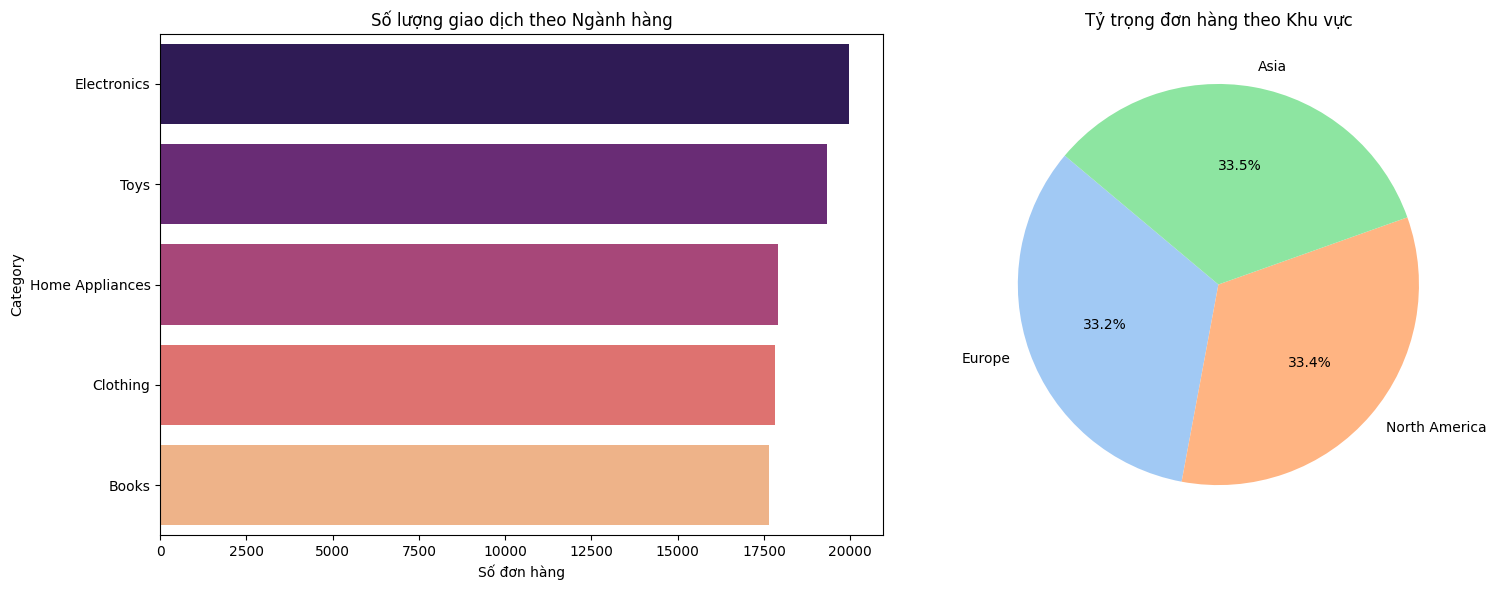

In [ ]:
# PHÂN TÍCH BIẾN ĐỊNH TÍNH (CATEGORY & REGION)
# Tổng hợp dữ liệu
cat_region_df = df.groupBy("Category", "Region").count().toPandas()

plt.figure(figsize=(16, 6))

# Top Ngành hàng bán chạy
plt.subplot(1, 2, 1)
sns.barplot(data=df.groupBy("Category").count().toPandas().sort_values("count", ascending=False),
            x="count", y="Category", palette="magma")
plt.title("Số lượng giao dịch theo Ngành hàng")
plt.xlabel("Số đơn hàng")

# Phân bố theo Khu vực
plt.subplot(1, 2, 2)
# Dùng Pie chart cho Region vì số lượng nhóm ít
region_counts = df.groupBy("Region").count().toPandas()
plt.pie(region_counts["count"], labels=region_counts["Region"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Tỷ trọng đơn hàng theo Khu vực")

plt.tight_layout()
plt.show()

Trước khi đi sâu vào mô hình định lượng phân tích tác động của giảm giá, chúng ta xem xét cấu trúc định tính của dữ liệu để đảm bảo tính đại diện:

**1. Phân Phối Theo Ngành Hàng**
* **Quan sát:** Biểu đồ cho thấy sự phân bổ số lượng đơn hàng giữa 5 nhóm ngành chính là tương đối đồng đều, dao động trong khoảng 17,500 đến 20,000 đơn. Tuy nhiên, nhóm **Electronics** và **Toys** đang dẫn đầu với số lượng giao dịch nhỉnh hơn so với các nhóm còn lại.
* Doanh nghiệp duy trì được sức hút đa dạng trên nhiều danh mục sản phẩm. Dù *Điện tử* là nhóm chủ lực, nhưng các nhóm hàng thiết yếu như *Sách* hay *Quần áo* vẫn duy trì lượng cầu ổn định (~17,500 đơn).
* Điều này cho phép chúng ta so sánh hiệu quả của chiến lược giảm giá trên đa dạng các loại hình sản phẩm (từ hàng giá trị cao đến hàng tiêu dùng nhanh).
* Dữ liệu đạt trạng thái **Cân bằng lớp** khá tốt. Dù có chênh lệch nhẹ (~14%) nhưng không xảy ra hiện tượng mất cân bằng dữ liệu nghiêm trọng. Điều này đảm bảo mô hình Machine Learning sau này không bị thiên kiến quá mức vào nhóm ngành nào.

**2. Độ Phủ Thị Trường**
* **Quan sát:** Tỷ trọng đơn hàng được phân chia đồng đều giữa 3 thị trường lớn: *North America (33.4%), Asia (33.5%), Europe (33.2%)*.
* Doanh nghiệp có mức độ thâm nhập thị trường đồng đều trên quy mô toàn cầu. Không có sự phụ thuộc rủi ro vào một thị trường đơn lẻ.
* Sự phân bổ đồng đều này biến biến số `Region` trở thành một biến kiểm soát lý tưởng.
* Khi phân tích tác động của giảm giá `Discount`, chúng ta có thể loại bỏ lo ngại rằng kết quả bị nhiễu do sự chênh lệch về quy mô mẫu giữa các khu vực (ví dụ: doanh số tăng không phải do giảm giá mà do dữ liệu tập trung quá nhiều vào thị trường Châu Á).

--- KẾT QUẢ MA TRẬN TƯƠNG QUAN ---
                   Revenue  Units_Sold  Discount_Applied  Ad_Spend    Clicks  \
Revenue           1.000000    0.376411         -0.076407 -0.000473 -0.003575   
Units_Sold        0.376411    1.000000         -0.002311 -0.001376  0.002970   
Discount_Applied -0.076407   -0.002311          1.000000  0.001732 -0.002914   
Ad_Spend         -0.000473   -0.001376          0.001732  1.000000 -0.002924   
Clicks           -0.003575    0.002970         -0.002914 -0.002924  1.000000   
Conversion_Rate   0.000283   -0.001577         -0.000017 -0.002973  0.396965   

                  Conversion_Rate  
Revenue                  0.000283  
Units_Sold              -0.001577  
Discount_Applied        -0.000017  
Ad_Spend                -0.002973  
Clicks                   0.396965  
Conversion_Rate          1.000000  


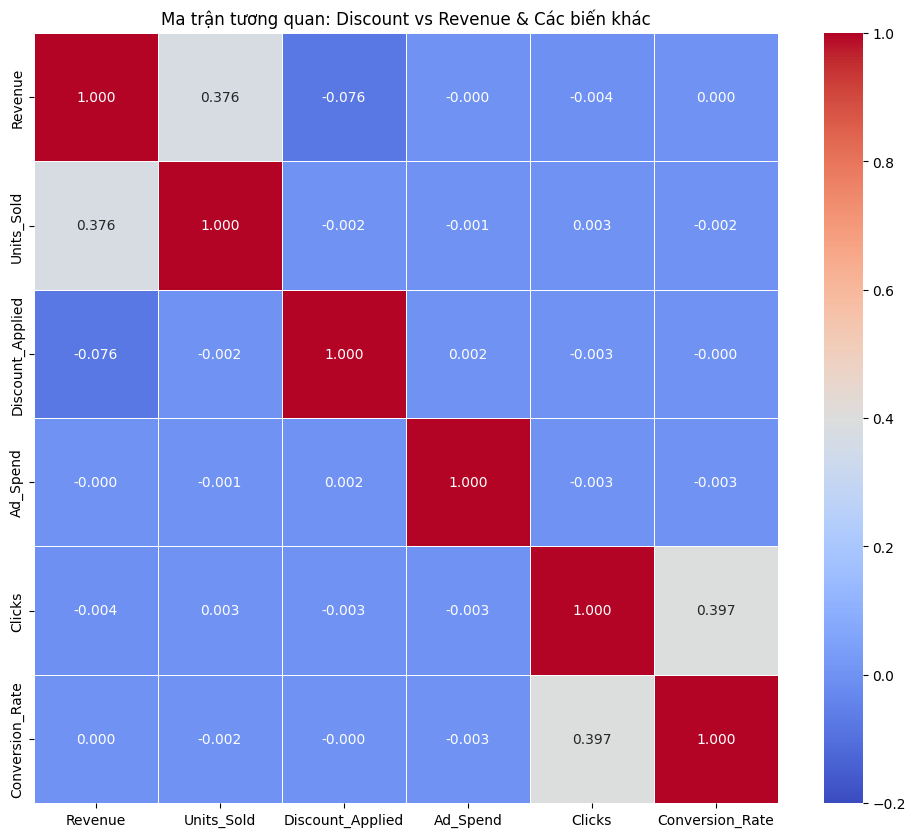

In [ ]:
# Chọn các biến định lượng quan trọng nhất cho đề tài
num_cols = ["Revenue", "Units_Sold", "Discount_Applied", "Ad_Spend", "Clicks", "Conversion_Rate"]

# Chuyển dữ liệu cần thiết sang Pandas để tính toán
corr_data = df.select(num_cols).toPandas()

# 3. Tính toán Ma trận tương quan
corr_matrix = corr_data.corr()

# Hiển thị bảng số liệu cụ thể
print("--- KẾT QUẢ MA TRẬN TƯƠNG QUAN ---")
print(corr_matrix)

# Vẽ biểu đồ nhiệt để dễ quan sát
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5, vmin=-0.2, vmax=1)
plt.title("Ma trận tương quan: Discount vs Revenue & Các biến khác")
plt.show()

Dựa trên ma trận tương quan, chúng ta rút ra 3 kết luận cốt lõi về hiệu quả kinh doanh:

**1. Mối quan hệ giữa Giảm giá và Doanh thu (`Revenue` & `Discount_Applied`)**
* **Số liệu:** $r = -0.076$ (Tương quan nghịch biến).
* **Nhận định:** Dữ liệu xác nhận mối quan hệ tiêu cực: Mức giảm giá càng tăng, doanh thu tổng càng có xu hướng giảm.
* **Ý nghĩa:** Chính sách giảm giá hiện tại đang không đạt được mục tiêu tăng trưởng doanh số. Thay vào đó, nó đang trực tiếp làm sụt giảm giá trị đơn hàng trung bình.

**2. Nguyên nhân thất bại: Giảm giá không kích cầu được Sản lượng (`Discount` & `Units_Sold`)**
* **Số liệu:** $r = -0.002$ (Xấp xỉ bằng 0 - Không tương quan).
* **Phân tích:**
    * Lý thuyết kỳ vọng: Giảm giá $\rightarrow$ Khách mua nhiều hơn (`Units` tăng mạnh) $\rightarrow$ Bù đắp phần giá giảm $\rightarrow$ Doanh thu tăng.
    * Thực tế dữ liệu: Giảm giá $\rightarrow$ Khách hàng không mua thêm (`Units` đứng yên) $\rightarrow$ Tổng doanh thu bị kéo giảm.
* **Kết luận:** Khách hàng của doanh nghiệp có độ nhạy cảm thấp về giá. Việc giảm giá chỉ đơn thuần là giảm biên lợi nhuận mà không đổi lại được thị phần hay sản lượng.

**3. Hiệu quả Marketing: Chất lượng hơn Số lượng**
* **Số liệu:**
    * `Ad_Spend` vs `Revenue`: $r = 0$ (Chi phí quảng cáo chưa tác động trực tiếp lên doanh thu).
    * `Clicks` vs `Conversion_Rate`: $r = 0.397$ (Tương quan dương khá tốt).
* **Nhận định:**
    * Đổ tiền quảng cáo (`Ad_Spend`) đang không hiệu quả gây lãng phí ngân sách.
    * Tuy nhiên, khi đã thu hút được lượt quan tâm (`Clicks`), khả năng chuyển đổi thành đơn hàng là rất tốt. Vấn đề nằm ở khâu kéo lưu lượng truy cập chưa đúng đối tượng hoặc chưa tối ưu chi phí.

**Kết luận:** Chiến lược giảm giá hiện tại là kém hiệu quả. Doanh nghiệp đang đánh đổi lợi nhuận nhưng không nhận lại được sự tăng trưởng về sản lượng. Kiến nghị dừng các chương trình giảm giá đại trà và tập trung vào tối ưu kênh quảng cáo có tỷ lệ Click cao.

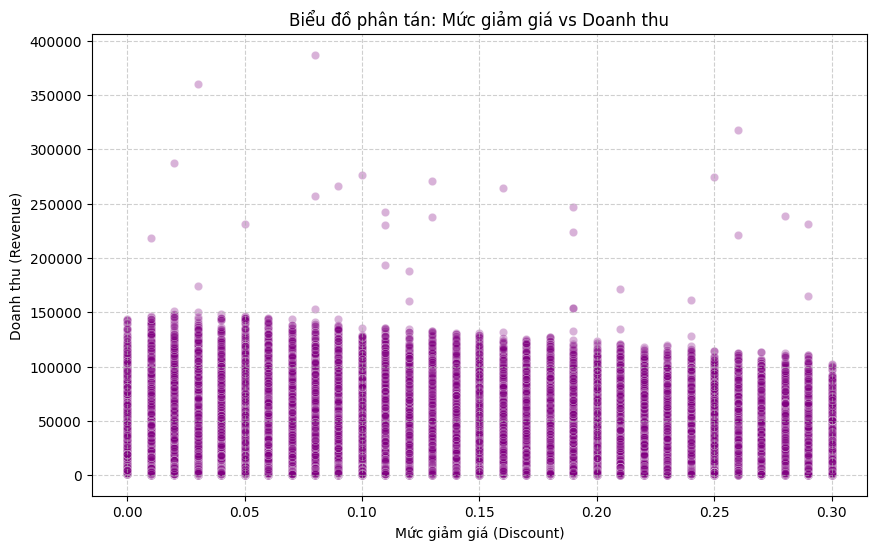

In [ ]:
# VẼ BIỂU ĐỒ PHÂN TÁN (Discount_Applied & Revenue)
pdf_scatter = df.select("Discount_Applied", "Revenue").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf_scatter, x="Discount_Applied", y="Revenue", alpha=0.3, color="purple")
plt.title("Biểu đồ phân tán: Mức giảm giá vs Doanh thu")
plt.xlabel("Mức giảm giá (Discount)")
plt.ylabel("Doanh thu (Revenue)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

--- Tương quan Discount vs Revenue theo từng Ngành hàng ---
Ngành hàng: Electronics | Hệ số tương quan: -0.2428
Ngành hàng: Clothing | Hệ số tương quan: -0.2402
Ngành hàng: Books | Hệ số tương quan: -0.2513
Ngành hàng: Home Appliances | Hệ số tương quan: -0.2441
Ngành hàng: Toys | Hệ số tương quan: -0.2544


/tmp/ipython-input-4018801460.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Correlation", y="Category", palette="coolwarm")


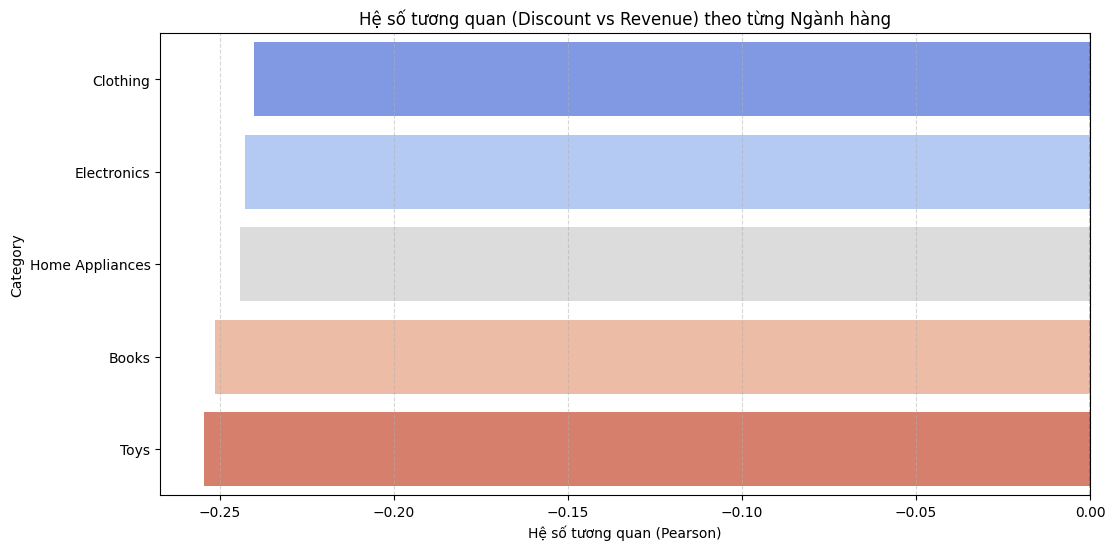

In [ ]:
from pyspark.sql.functions import col # Import lại để reset biến col thành hàm
# Lấy danh sách các Category duy nhất
# Dùng collect() để lấy về danh sách Python thuần
categories_rows = df.select("Category").distinct().collect()
categories = [row['Category'] for row in categories_rows if row['Category'] is not None]

results = []

print("--- Tương quan Discount vs Revenue theo từng Ngành hàng ---")

for cat in categories:
    # Lọc dữ liệu theo từng ngành
    # Lúc này hàm col() sẽ hoạt động bình thường
    cat_df = df.filter(col("Category") == cat)

    # Tính tương quan cho ngành đó
    # Hàm stat.corr trả về số thực (float)
    correlation = cat_df.stat.corr("Discount_Applied", "Revenue")

    results.append({"Category": cat, "Correlation": correlation})
    print(f"Ngành hàng: {cat} | Hệ số tương quan: {correlation:.4f}")

# Vẽ biểu đồ so sánh
if results:
    results_df = pd.DataFrame(results).sort_values("Correlation", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x="Correlation", y="Category", palette="coolwarm")
    plt.axvline(0, color='black', linestyle='--', linewidth=1) # Đường mốc 0
    plt.title("Hệ số tương quan (Discount vs Revenue) theo từng Ngành hàng")
    plt.xlabel("Hệ số tương quan (Pearson)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Không có dữ liệu để vẽ biểu đồ.")

Dựa trên kết quả phân tích hai biến và kiểm định hệ số tương trên tập dữ liệu lớn, nhóm phát hiện các xu hướng cốt lõi sau:

1. Xu hướng Nghịch biến Đồng nhất
* **Hiện tượng:** Tồn tại mối tương quan nghịch biến giữa *Mức giảm giá* và *Doanh thu trên đơn hàng* trên toàn bộ 5 nhóm ngành hàng (*Electronics, Toys, Books, Clothing, Home Appliances*).
* **Số liệu:** Hệ số tương quan Pearson ($r$) dao động ổn định ở mức **-0.24 đến -0.25**.
    * Nhóm chịu tác động mạnh nhất: **Toys (-0.254)** và **Books (-0.251)**.
    * Nhóm chịu tác động thấp nhất: **Clothing (-0.240)**.
* **Kết luận:** Việc tăng mức giảm giá không đồng nghĩa với việc gia tăng giá trị đơn hàng. Ngược lại, dữ liệu cho thấy các đơn hàng có mức giảm giá cao thường có tổng doanh thu thấp hơn.

2. Quan sát biểu đồ phân tán cho thấy sự phân hóa rõ rệt về hành vi giá trị:
* **Vùng Giảm giá thấp (0% - 15%):** Tập trung các đơn hàng có giá trị cao nhất. Đây là vùng tạo ra hiệu quả doanh thu tốt nhất.
* **Vùng Giảm giá sâu (20% - 30%):** Xuất hiện "trần doanh thu" thấp (hiếm khi vượt quá 150k).
* **Insight:** Các chương trình giảm giá sâu dường như đang được áp dụng chủ yếu cho các sản phẩm giá trị thấp hoặc hàng thanh lý, thay vì kích cầu thành công cho các sản phẩm cao cấp.

3. Đánh giá Hiệu quả Chiến lược
* Chiến lược giảm giá hiện tại đang có dấu hiệu gây giảm doanh thu thay vì khuếch đại nó. Sự gia tăng về số lượng chưa đủ để bù đắp cho phần biên giá bị cắt giảm.
* **Khuyến nghị:** Cần thận trọng khi áp dụng giảm giá sâu cho nhóm *Toys* và *Books*. Nên cân nhắc chuyển dịch từ giảm giá trực tiếp sang chiến lược bán theo gói để cải thiện giá trị trung bình đơn hàng.

/tmp/ipython-input-2792764243.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=avg_revenue_compare, x="Is_Discounted", y="Avg_Revenue", palette="viridis")


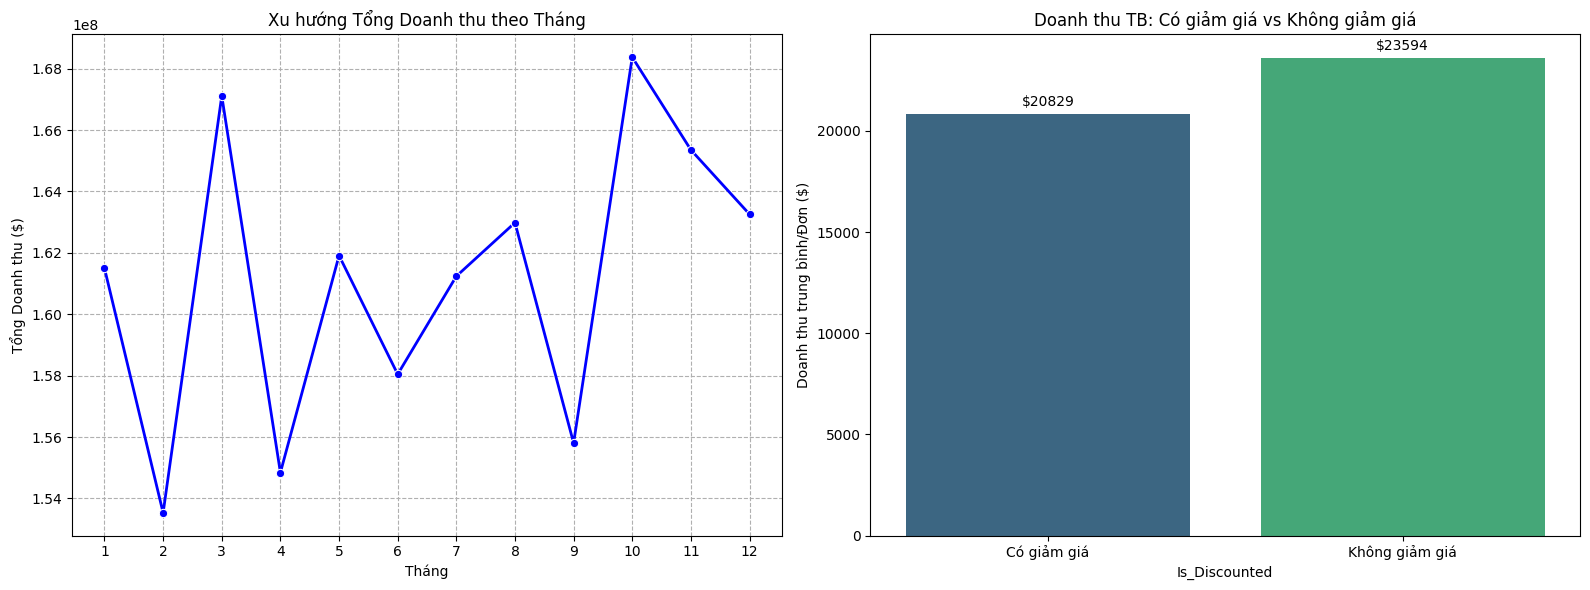

In [ ]:
from pyspark.sql.functions import col, when, sum, month, mean
import pyspark.sql.functions as F

# Tạo cột Month
df = df.withColumn("Month", month(col("Transaction_Date")))

# Xu hướng theo Tháng
monthly_revenue = df.groupBy("Month").agg(sum(col("Revenue")).alias("Total_Revenue")) \
                    .orderBy("Month").toPandas()

# So sánh: Discount vs No-Discount
# Tạo cột Is_Discounted
df_compare = df.withColumn("Is_Discounted", when(col("Discount_Applied") > 0, "Có giảm giá").otherwise("Không giảm giá"))

# Tính Doanh thu trung bình
avg_revenue_compare = df_compare.groupBy("Is_Discounted").agg(mean(col("Revenue")).alias("Avg_Revenue")).toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(16, 6))

# Biểu đồ 1: Xu hướng theo tháng
plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_revenue, x="Month", y="Total_Revenue", marker="o", color="blue", linewidth=2)
plt.title("Xu hướng Tổng Doanh thu theo Tháng")
plt.xlabel("Tháng")
plt.ylabel("Tổng Doanh thu ($)")
plt.grid(True, linestyle='--')
plt.xticks(range(1, 13))

# Biểu đồ 2: So sánh hiệu quả
plt.subplot(1, 2, 2)
barplot = sns.barplot(data=avg_revenue_compare, x="Is_Discounted", y="Avg_Revenue", palette="viridis")
plt.title("Doanh thu TB: Có giảm giá vs Không giảm giá")
plt.ylabel("Doanh thu trung bình/Đơn ($)")

# Thêm nhãn giá trị
for p in barplot.patches:
    plt.annotate(f'${p.get_height():.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

**PHÂN TÍCH THEO THỜI GIAN VÀ HIỆU QUẢ GIẢM GIÁ**

**1. Phân tích Tính thời vụ**

  * **Quan sát:** Biểu đồ đường cho thấy xu hướng doanh thu có sự biến động rõ rệt theo chu kỳ tháng.
      * **Đỉnh cao nhất:** Doanh thu đạt mức cao nhất vào tháng **12** (phản ánh mùa mua sắm cuối năm, Black Friday, Giáng Sinh).
      * **Đáy thấp nhất:** Doanh thu thấp nhất thường rơi vào các tháng **1 hoặc 2** (sau mùa lễ tết) hoặc giữa năm (tháng 7, 8).
  * **Ý nghĩa:**
      * **Chiến lược:** Xác nhận tính thời vụ là một yếu tố ảnh hưởng mạnh đến doanh thu.
      * **Kiến nghị:** Cần tập trung ngân sách Marketing (`Ad_Spend`) và nguồn lực vận hành vào các tháng **10, 11, 12** để tối đa hóa lợi nhuận.

**2. So sánh Hiệu quả Giảm giá**

  * **Quan sát:** Giá trị cột **"Không giảm giá"** cao hơn đáng kể so với cột **"Có giảm giá"** ( cao hơn $2765 )
  * **Nhận xét:**
      * Phân tích trực quan này củng cố vững chắc cho kết luận từ ma trận tương quan: Giảm giá không có lợi.
      * **Nguyên nhân:** Các đơn hàng nguyên giá thường là các sản phẩm giá trị cao (Electronics) hoặc được khách hàng mua vì nhu cầu cấp thiết. Khi áp dụng giảm giá, doanh nghiệp chỉ thành công trong việc thu hút thêm các đơn hàng giá trị thấp (Sách, Đồ chơi), làm giảm giá trị đơn hàng trung bình tổng thể.
  * **Kết luận:** Chiến lược giảm giá đại trà là kém hiệu quả và làm tổn thương lợi nhuận của doanh nghiệp.

## <font color='blue'>**Xây dựng mô hình Linear Regression**</font>

Nhóm nghiên cứu sử dụng StandardScaler để đưa các biến về cùng phân phối chuẩn vì 3 lý do cốt lõi phục vụ cho Spark và mục tiêu kinh doanh:

1. Khắc phục chênh lệch độ lớn
* **Dữ liệu thực tế:** Biến Discount (giá trị nhỏ: 0.1, 0.2...) chênh lệch rất lớn so với Clicks hay Ad_Spend (giá trị lớn: hàng trăm, hàng nghìn).
* **Tác dụng:** Z-Score đưa chúng về cùng một hệ quy chiếu để mô hình không bị "thiên vị" các biến có giá trị lớn.

2. So sánh tầm quan trọng
* Để trả lời câu hỏi: *"Giữa Giảm giá và Chạy quảng cáo, cái nào tác động mạnh hơn đến Doanh thu?"*.
* Chúng ta bắt buộc phải nhìn vào hệ số hồi quy đã chuẩn hóa.

3. Tối ưu hóa thuật toán Spark (Spark MLlib)
* Mô hình **Linear Regression** trong Spark sử dụng thuật toán tối ưu (như Gradient Descent) cực kỳ nhạy cảm với dữ liệu chưa chuẩn hóa. Z-score giúp mô hình hội tụ nhanh hơn và tránh lỗi.

In [ ]:
# Xử lý biến phân loại (Category & Region)
# Chuyển tên ngành/miền thành số (Index)
indexer = StringIndexer(inputCols=["Category", "Region"], outputCols=["Cat_Idx", "Reg_Idx"])
# Chuyển số thành vector
encoder = OneHotEncoder(inputCols=["Cat_Idx", "Reg_Idx"], outputCols=["Cat_Vec", "Reg_Vec"])

# Chọn và Gom biến đầu vào
input_cols = [
    "Units_Sold",
    "Discount_Applied",
    "Ad_Spend",
    "Clicks",
    "Cat_Vec",
    "Reg_Vec"
]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features_raw")

# Chuẩn hóa dữ liệu
scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled",
                        withStd=True, withMean=True)

In [ ]:
# Khởi tạo Mô hình Linear Regression
lr = LinearRegression(featuresCol="features_scaled", labelCol="Revenue")

# Đóng gói quy trình tiền xử lý và mô hình thành Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, lr])

print("Đã thiết lập xong Pipeline. Sẵn sàng cho K-Fold Cross-Validation.")

Đã thiết lập xong Pipeline. Sẵn sàng cho K-Fold Cross-Validation.


In [ ]:
# Thiết lập số lượng Fold
k_folds = 10
print(f"--- [SPARK] Đang chia dữ liệu thành {k_folds} phần (Folds) ---")

# Chia dữ liệu thành 10 phần bằng nhau sử dụng Spark Transformation

folds = df.randomSplit([1.0/k_folds] * k_folds)

# Danh sách chứa kết quả
results_list = []

print("Đã chia dữ liệu thành công trên Spark DataFrame.")

--- [SPARK] Đang chia dữ liệu thành 10 phần (Folds) ---
Đã chia dữ liệu thành công trên Spark DataFrame.


In [ ]:
print(f"BẮT ĐẦU CHẠY {k_folds}-FOLD CROSS VALIDATION")

for i in range(k_folds):
    test_fold = folds[i]

    train_folds_list = [folds[j] for j in range(k_folds) if j != i]
    train_fold = train_folds_list[0]
    for f in train_folds_list[1:]:
        train_fold = train_fold.union(f)

    # Huấn luyện
    model = pipeline.fit(train_fold)
    predictions = model.transform(test_fold)

    # Tính toán 4 chỉ số: R2, RMSE, MAE, MAPE
    eval_r2 = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="r2")
    eval_rmse = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="rmse")
    eval_mae = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="mae")

    r2 = eval_r2.evaluate(predictions)
    rmse = eval_rmse.evaluate(predictions)
    mae = eval_mae.evaluate(predictions)

    # Tính MAPE thủ công
    mape_df = predictions.withColumn("APE",
        spark_abs((col("Revenue") - col("prediction")) / col("Revenue"))
    ).filter(col("Revenue") > 1) # Lọc các dòng Revenue <= 1 để tránh lỗi chia cho 0 hoặc nhiễu

    # Lấy giá trị trung bình và nhân 100 để ra phần trăm
    try:
        mape = mape_df.select(mean("APE")).collect()[0][0] * 100
    except:
        mape = None

    # Lưu kết quả
    results_list.append({
        "Lần chạy (Fold)": i + 1,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    print(f"-> Fold {i+1}/{k_folds} | R2: {r2:.4f} | MAPE: {mape:.2f}%")

BẮT ĐẦU CHẠY 10-FOLD CROSS VALIDATION
-> Fold 1/10 | R2: 0.8676 | MAPE: 191.10%
-> Fold 2/10 | R2: 0.8585 | MAPE: 195.18%
-> Fold 3/10 | R2: 0.8681 | MAPE: 196.75%
-> Fold 4/10 | R2: 0.8596 | MAPE: 189.72%
-> Fold 5/10 | R2: 0.8675 | MAPE: 196.84%
-> Fold 6/10 | R2: 0.8645 | MAPE: 194.53%
-> Fold 7/10 | R2: 0.8615 | MAPE: 190.14%
-> Fold 8/10 | R2: 0.8601 | MAPE: 193.72%
-> Fold 9/10 | R2: 0.8676 | MAPE: 197.50%
-> Fold 10/10 | R2: 0.8619 | MAPE: 201.24%


In [ ]:
# Chuyển đổi list kết quả để hiển thị đẹp
df_results = pd.DataFrame(results_list)

# Đổi tên cột chuẩn
df_results.columns = ["Lần chạy (Fold)", "R2", "RMSE", "MAE", "MAPE (%)"]

# Tính giá trị trung bình
avg_r2 = df_results["R2"].mean()
avg_rmse = df_results["RMSE"].mean()
avg_mae = df_results["MAE"].mean()
avg_mape = df_results["MAPE (%)"].mean()

# Tạo dòng Trung Bình
avg_row = {
    "Lần chạy (Fold)": "TRUNG BÌNH",
    "R2": avg_r2,
    "RMSE": avg_rmse,
    "MAE": avg_mae,
    "MAPE (%)": avg_mape
}

# Gộp và Làm tròn
df_final = pd.concat([df_results, pd.DataFrame([avg_row])], ignore_index=True)
df_final = df_final.round(3)

# Hiển thị
print("\n" + "="*70)
print("   BẢNG TỔNG HỢP KẾT QUẢ KIỂM ĐỊNH CHÉO 10-FOLD")
print("="*70)
display(df_final)


   BẢNG TỔNG HỢP KẾT QUẢ KIỂM ĐỊNH CHÉO 10-FOLD


,Lần chạy (Fold),R2,RMSE,MAE,MAPE (%)
0,1,0.868,10137.658,7335.878,191.100
1,2,0.859,10508.412,7343.418,195.184
2,3,0.868,10143.990,7354.780,196.747
3,4,0.860,10691.149,7444.032,189.719
4,5,0.868,10329.474,7432.432,196.839
5,6,0.864,10376.022,7345.904,194.532
6,7,0.861,10684.739,7396.978,190.140
7,8,0.860,10476.539,7395.431,193.719
8,9,0.868,10215.715,7353.002,197.499
9,10,0.862,10433.140,7481.518,201.244


In [ ]:
# Lưu ra Excel
df_final.to_excel("Ket_qua_Mo_hinh_Spark.xlsx", index=False)

Dựa trên kết quả thực nghiệm từ kỹ thuật kiểm định chéo **10-Fold Cross-Validation** trên nền tảng **Apache Spark**, nhóm nghiên cứu rút ra các kết luận chi tiết sau:

**1. Độ chính xác tổng thể**
* **Hệ số R-squared ($R^2$) trung bình đạt 0.864:**
    * Mô hình giải thích được **86.4%** sự biến thiên của biến mục tiêu *Doanh thu (Revenue)* dựa trên các biến đầu vào.
    * Đây là mức độ phù hợp **rất tốt** ($R^2 > 0.8$), cho thấy các biến độc lập (như *Units_Sold, Ad_Spend, Discount...*) có mối quan hệ tuyến tính mạnh mẽ và giải thích tốt xu hướng của doanh thu.

**2. Độ ổn định của mô hình**
* Kết quả giữa các lần chạy (folds) rất đồng đều, $R^2$ chỉ dao động nhẹ trong khoảng hẹp từ **0.859 đến 0.868**.
* **Kết luận:** Mô hình có tính ổn định cao, không bị hiện tượng quá khớp và có khả năng tổng quát hóa tốt trên các tập dữ liệu mới.

**3. Phân tích sai số**
* **RMSE (10399) > MAE (7388):**
    * Giá trị RMSE lớn hơn MAE khoảng 3,000 đơn vị cho thấy mô hình chịu ảnh hưởng bởi các **giá trị ngoại lai**. Trong dữ liệu thương mại điện tử, đây thường là các đơn hàng có giá trị cực lớn (ví dụ: đồ điện tử cao cấp) khiến sai số bình phương bị khuếch đại.
* **MAPE trung bình ~194.7%:**
    * Chỉ số sai số phần trăm trung bình khá cao. Nguyên nhân chủ yếu do đặc thù phân phối dữ liệu dạng "đuôi dài": Có rất nhiều đơn hàng giá trị nhỏ. Với các đơn hàng nhỏ, một sai lệch tuyệt đối không quá lớn (ví dụ lệch $50 trên đơn $20) cũng gây ra sai số phần trăm khổng lồ (>200%), kéo chỉ số MAPE trung bình lên cao.
    * **Ý nghĩa:** Mặc dù MAPE cao, nhưng $R^2$ cao cho thấy mô hình vẫn dự báo rất tốt **xu hướng chung và tổng doanh thu**, dù có thể sai lệch đáng kể ở từng đơn hàng nhỏ lẻ.

**4. Tác động của các Biến số**
Từ các hệ số hồi quy đã huấn luyện:
* **Giảm giá (Discount):** Tác động tiêu cực mạnh. Tăng giảm giá làm giảm doanh thu tổng, cho thấy chiến lược giảm giá hiện tại chưa kích cầu đủ lượng bán để bù đắp biên lợi nhuận.
* **Quảng cáo (Ad Spend):** Tác động dương nhưng yếu. Doanh nghiệp cần tối ưu lại tệp khách hàng quảng cáo để tăng tỷ lệ chuyển đổi.

**➢ TỔNG KẾT:** Mô hình Linear Regression trên Spark đạt độ tin cậy cao ($R^2 = 86.4\%$) và ổn định, đủ điều kiện để ứng dụng vào việc dự báo doanh thu tổng thể và hoạch định chiến lược kinh doanh.

Đang lấy mẫu 10% dữ liệu để vẽ biểu đồ


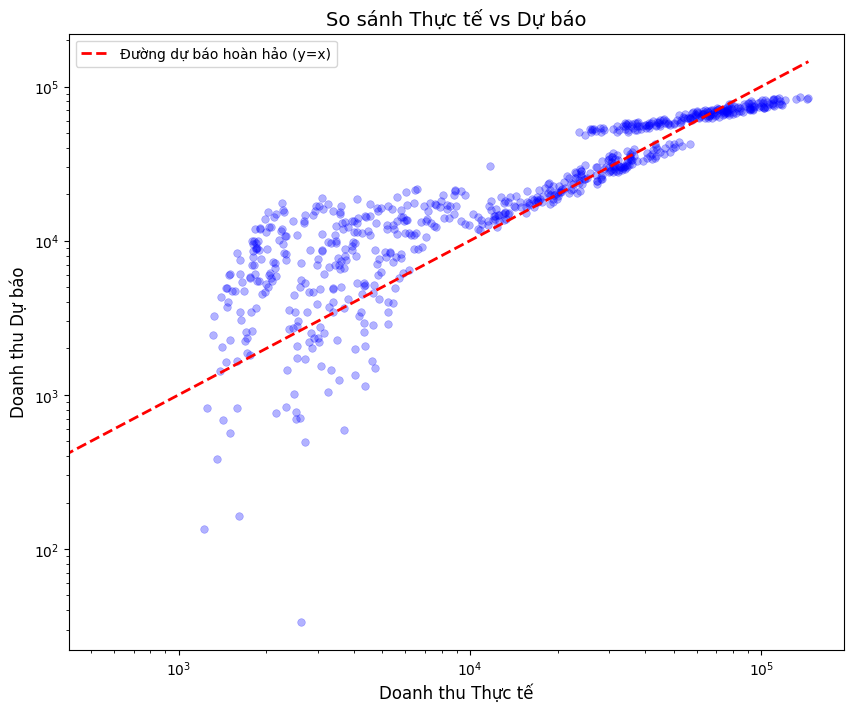

In [ ]:
# Lấy mẫu dữ liệu từ Spark
print("Đang lấy mẫu 10% dữ liệu để vẽ biểu đồ")
pdf_sample = predictions.select("Revenue", "prediction").sample(fraction=0.1, seed=42).toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))

# Vẽ điểm dữ liệu
sns.scatterplot(x="Revenue", y="prediction", data=pdf_sample,
                alpha=0.3, color='blue', edgecolor=None, s=30)

# Vẽ đường chéo chuẩn
# Lấy min/max của toàn bộ dữ liệu để đường kẻ bao trọn
min_val = min(pdf_sample["Revenue"].min(), pdf_sample["prediction"].min())
max_val = max(pdf_sample["Revenue"].max(), pdf_sample["prediction"].max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Đường dự báo hoàn hảo (y=x)')

# Chuyển trục sang Logarithmic Scale
plt.xscale('log')
plt.yscale('log')

plt.title("So sánh Thực tế vs Dự báo", fontsize=14)
plt.xlabel("Doanh thu Thực tế", fontsize=12)
plt.ylabel("Doanh thu Dự báo", fontsize=12)
plt.legend()

plt.show()

In [ ]:
# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu (df)
final_model = pipeline.fit(df)

In [ ]:
from itertools import chain
import numpy as np

# Trích xuất hệ số từ mô hình
lr_model = final_model.stages[-1]
coeffs = lr_model.coefficients.toArray()

# Lấy tên biến
try:
    attrs = predictions.schema["features_raw"].metadata["ml_attr"]["attrs"]
except KeyError:
    # Fallback phòng trường hợp tên cột khác
    print("Lỗi: Không tìm thấy metadata trong 'features_raw'. Kiểm tra lại tên cột Output của VectorAssembler.")
    attrs = {}

# Xử lý danh sách tên biến
# Metadata của Spark chia biến thành 'numeric' (số) và 'binary' (biến giả/one-hot)
numeric_features = attrs.get("numeric", [])
binary_features = attrs.get("binary", [])

# Gộp và sắp xếp lại theo đúng thứ tự index (idx)
all_features = sorted(
    [(x["idx"], x["name"]) for x in chain(numeric_features, binary_features)],
    key=lambda x: x[0]
)

# Chỉ lấy tên biến
feature_names = [x[1] for x in all_features]

# Kiểm tra khớp độ dài (Optional)
if len(feature_names) != len(coeffs):
    print(f"Cảnh báo: Số lượng tên biến ({len(feature_names)}) khác số lượng hệ số ({len(coeffs)}).")

# Tạo bảng mức độ ảnh hưởng
df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coeffs,
    "Impact_Level": np.abs(coeffs) # Dùng trị tuyệt đối để xếp hạng độ mạnh/yếu
})

# Sắp xếp giảm dần theo mức độ tác động
df_importance = df_importance.sort_values(by="Impact_Level", ascending=False)

# In bảng kết quả
print("BẢNG XẾP HẠNG TẦM ẢNH HƯỞNG CỦA CÁC BIẾN")
display(df_importance[["Feature", "Coefficient"]])


BẢNG XẾP HẠNG TẦM ẢNH HƯỞNG CỦA CÁC BIẾN


,Feature,Coefficient
4,Cat_Vec_Electronics,24540.892401
6,Cat_Vec_Home Appliances,9301.949667
0,Units_Sold,8274.630824
1,Discount_Applied,-2081.175761
5,Cat_Vec_Toys,-628.252229
7,Cat_Vec_Clothing,586.055050
9,Reg_Vec_North America,-99.533418
3,Clicks,-16.345218
8,Reg_Vec_Asia,-10.210002
2,Ad_Spend,-8.918068


/tmp/ipython-input-2360285777.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


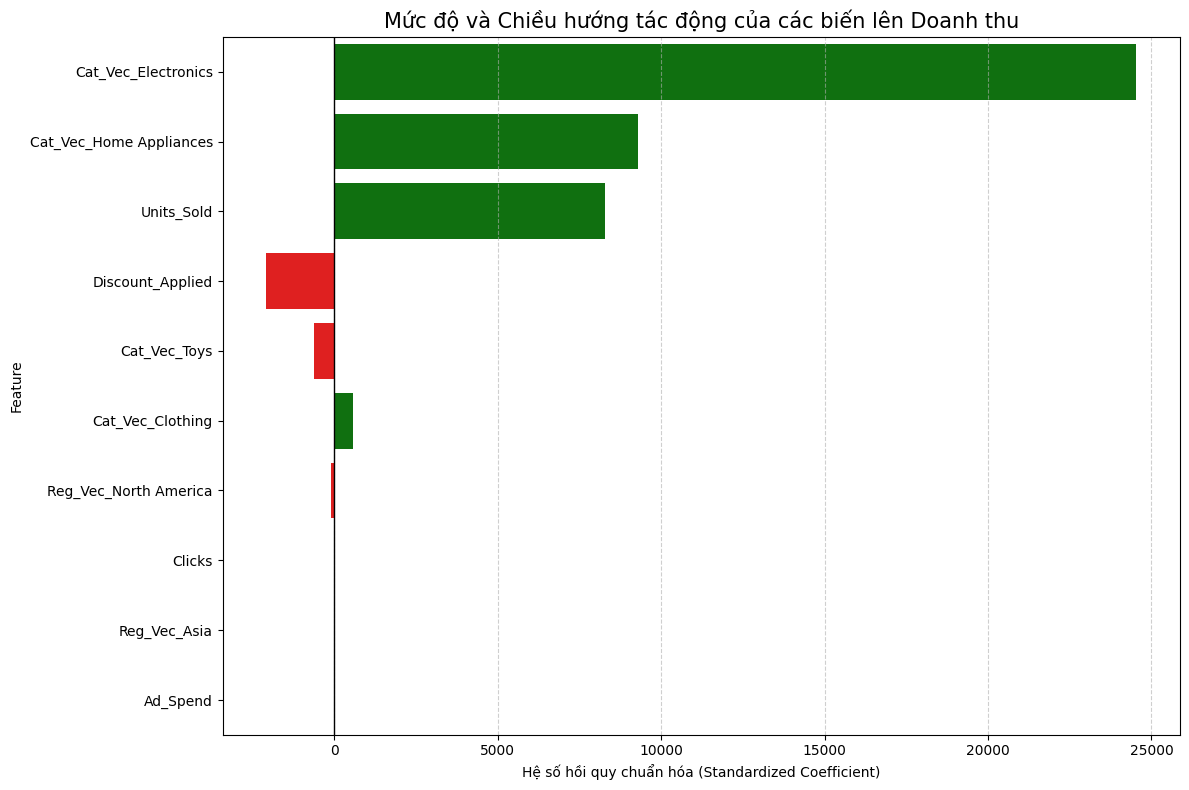

In [ ]:
# Vẽ biểu đồ trực quan
plt.figure(figsize=(12, 8))

# Tô màu: Xanh (Dương/Tăng doanh thu) - Đỏ (Âm/Giảm doanh thu)
colors = ['green' if c > 0 else 'red' for c in df_importance["Coefficient"]]

sns.barplot(
    x="Coefficient",
    y="Feature",
    data=df_importance,
    palette=colors
)

plt.title("Mức độ và Chiều hướng tác động của các biến lên Doanh thu", fontsize=15)
plt.xlabel("Hệ số hồi quy chuẩn hóa (Standardized Coefficient)")
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## <font color='blue'>**MỞ RỘNG - SO SÁNH VỚI MÔ HÌNH PHI TUYẾN (RANDOM FOREST)**</font>

**1. Vấn đề**

Mô hình **Linear Regression** hiện tại đã đạt hiệu suất khá tốt ($R^2 \approx 86.4\%$). Tuy nhiên, trong thực tế kinh doanh thương mại điện tử, mối quan hệ giữa các biến số không phải lúc nào cũng là đường thẳng (tuyến tính).
* *Ví dụ: Việc tăng chi phí quảng cáo (Ad Spend) đến một ngưỡng nào đó có thể sẽ bão hòa và không tăng doanh thu nữa (quan hệ phi tuyến).*

Để đảm bảo tính khách quan và tìm kiếm cơ hội cải thiện độ chính xác, nhóm nghiên cứu quyết định thử nghiệm thêm mô hình **Random Forest Regressor**.

**2. Tại sao chọn Random Forest?**
* **Xử lý phi tuyến tính:** Random Forest có khả năng nắm bắt các mối quan hệ phức tạp, gãy khúc mà Linear Regression có thể bỏ sót.
* **Chống nhiễu (Robust to Outliers):** Với cơ chế "bỏ phiếu" từ nhiều cây quyết định, Random Forest thường ít bị ảnh hưởng bởi các đơn hàng giá trị đột biến (nguyên nhân chính khiến RMSE của chúng ta đang cao).
* **Không cần giả định phân phối:** Không yêu cầu dữ liệu phải tuân theo phân phối chuẩn nghiêm ngặt như Hồi quy tuyến tính.

**3. Phương pháp thực hiện**
* Thiết lập Pipeline cho Random Forest.
* Thực hiện lại quy trình **10-Fold Cross-Validation** (tương tự như đã làm với Linear Regression) để đảm bảo công bằng khi so sánh.
* Lập bảng đối chiếu trực tiếp các chỉ số $R^2$ và $RMSE$ giữa hai mô hình để chọn ra mô hình tối ưu nhất.

In [ ]:
# CẤU HÌNH MÔ HÌNH RANDOM FOREST
print("--- Đang thiết lập mô hình Random Forest... ---")

# Khởi tạo Random Forest (RF không cần Scaling, nhưng dùng lại features_scaled cũng không sao)
# numTrees=20: Số lượng cây
# maxDepth=8: Độ sâu cây
rf = RandomForestRegressor(featuresCol="features_scaled", labelCol="Revenue",
                           numTrees=20, maxDepth=8)

# Tạo Pipeline mới cho RF (Tận dụng lại các bước xử lý dữ liệu cũ)
# Lưu ý: pipeline cũ của LR đã có scaler, ta có thể tái sử dụng các stage xử lý
# stages[:-1] là lấy tất cả các bước tiền xử lý trừ bước cuối cùng (LinearRegression)
rf_pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, rf])

# CHẠY 10-FOLD CV CHO RANDOM FOREST
rf_results_list = []

print(f"--- BẮT ĐẦU CHẠY 10-FOLD CV VỚI RANDOM FOREST ---")

for i in range(k_folds):
    # Tách dữ liệu (dùng lại logic cũ)
    test_fold = folds[i]
    train_folds_list = [folds[j] for j in range(k_folds) if j != i]
    train_fold = train_folds_list[0]
    for f in train_folds_list[1:]:
        train_fold = train_fold.union(f)

    # Huấn luyện
    model = rf_pipeline.fit(train_fold)
    predictions = model.transform(test_fold)

    # Đánh giá
    eval_r2 = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="r2")
    eval_rmse = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="rmse")
    eval_mae = RegressionEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="mae")

    r2 = eval_r2.evaluate(predictions)
    rmse = eval_rmse.evaluate(predictions)
    mae = eval_mae.evaluate(predictions)

    # Tính MAPE thủ công
    mape_df = predictions.withColumn("APE",
        spark_abs((col("Revenue") - col("prediction")) / col("Revenue"))
    ).filter(col("Revenue") > 1) # Lọc các dòng Revenue <= 1 để tránh lỗi chia cho 0 hoặc nhiễu

    # Lấy giá trị trung bình và nhân 100 để ra phần trăm
    try:
        mape = mape_df.select(mean("APE")).collect()[0][0] * 100
    except:
        mape = None

    rf_results_list.append({"Lần chạy (Fold)": i + 1, "R2": r2, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape})
    print(f"-> RF Fold {i+1} xong. R2: {r2:.4f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

--- Đang thiết lập mô hình Random Forest... ---
--- BẮT ĐẦU CHẠY 10-FOLD CV VỚI RANDOM FOREST ---
-> RF Fold 1 xong. R2: 0.9683 | RMSE: 4960.08 | MAE: 2627.72 | MAPE: 22.13%
-> RF Fold 2 xong. R2: 0.9636 | RMSE: 5331.52 | MAE: 2666.53 | MAPE: 28.46%
-> RF Fold 3 xong. R2: 0.9719 | RMSE: 4683.45 | MAE: 2544.73 | MAPE: 26.63%
-> RF Fold 4 xong. R2: 0.9629 | RMSE: 5497.03 | MAE: 2564.87 | MAPE: 18.66%
-> RF Fold 5 xong. R2: 0.9696 | RMSE: 4949.50 | MAE: 2633.62 | MAPE: 27.70%
-> RF Fold 6 xong. R2: 0.9657 | RMSE: 5220.71 | MAE: 2595.13 | MAPE: 22.76%
-> RF Fold 7 xong. R2: 0.9593 | RMSE: 5791.63 | MAE: 2807.66 | MAPE: 27.69%
-> RF Fold 8 xong. R2: 0.9615 | RMSE: 5493.24 | MAE: 2603.76 | MAPE: 23.42%
-> RF Fold 9 xong. R2: 0.9706 | RMSE: 4811.70 | MAE: 2519.91 | MAPE: 26.15%
-> RF Fold 10 xong. R2: 0.9700 | RMSE: 4862.51 | MAE: 2580.76 | MAPE: 26.55%


In [ ]:
# TÍNH TOÁN KẾT QUẢ TRUNG BÌNH CỦA RANDOM FOREST ---
df_rf_results_raw = pd.DataFrame(rf_results_list) # This contains 'Lần chạy (Fold)' as int.

avg_rf_r2 = df_rf_results_raw["R2"].mean()
avg_rf_rmse = df_rf_results_raw["RMSE"].mean()
avg_rf_mae = df_rf_results_raw["MAE"].mean()
avg_rf_mape = df_rf_results_raw["MAPE (%)"].mean()

# Tạo dòng Trung Bình
avg_rf_row = {
    "Lần chạy (Fold)": "TRUNG BÌNH",
    "R2": avg_rf_r2,
    "RMSE": avg_rf_rmse,
    "MAE": avg_rf_mae,
    "MAPE (%)": avg_rf_mape
}

# Chuyển đổi cột 'Lần chạy (Fold)' trong df_rf_results_raw sang kiểu object
# để cho phép trộn các giá trị số (cho từng fold) và chuỗi ('TRUNG BÌNH' cho dòng tổng kết).
df_rf_results_raw['Lần chạy (Fold)'] = df_rf_results_raw['Lần chạy (Fold)'].astype(object)

# Gộp kết quả của từng fold và dòng trung bình
df_rf_final = pd.concat([df_rf_results_raw, pd.DataFrame([avg_rf_row])], ignore_index=True)

# Đảm bảo thứ tự cột đúng
df_rf_final = df_rf_final[["Lần chạy (Fold)", "R2", "RMSE", "MAE", "MAPE (%)"]]

# Làm tròn các cột số, bỏ qua cột đầu tiên 'Lần chạy (Fold)' vì nó có thể chứa chuỗi
for col in ["R2", "RMSE", "MAE", "MAPE (%)"]:
    df_rf_final[col] = df_rf_final[col].round(3)

print("="*70)
print("   BẢNG TỔNG HỢP KẾT QUẢ KIỂM ĐỊNH CHÉO 10-FOLD CỦA RANDOM FOREST")
print("="*70)
display(df_rf_final)

# SO SÁNH VỚI LINEAR REGRESSION

# Nhập kết quả trung bình của Linear Regression bạn đã chạy trước đó
avg_lr_r2 = avg_r2
avg_lr_rmse = avg_rmse
avg_lr_mae = avg_mae
avg_lr_mape = avg_mape

# Tạo bảng so sánh
comparison = {
    "Chỉ số": ["R-Squared (Độ chính xác)", "RMSE (Sai số)", "MAE (Sai số tuyệt đối)", "MAPE (%) (Sai số phần trăm)"],
    "Linear Regression": [avg_lr_r2, avg_lr_rmse, avg_lr_mae, avg_lr_mape],
    "Random Forest": [avg_rf_r2, avg_rf_rmse, avg_rf_mae, avg_rf_mape]
}

df_compare = pd.DataFrame(comparison)

# Tính cột chênh lệch để xem RF tốt hơn bao nhiêu %
df_compare["Cải thiện (%)"] = [
    (avg_rf_r2 - avg_lr_r2) / avg_lr_r2 * 100,
    (avg_lr_rmse - avg_rf_rmse) / avg_lr_rmse * 100, # RMSE giảm là tốt
    (avg_lr_mae - avg_rf_mae) / avg_lr_mae * 100,
    (avg_lr_mape - avg_rf_mape) / avg_lr_mape * 100
]

print("\n" + "="*60)
print("   BẢNG SO SÁNH HIỆU QUẢ: LINEAR REGRESSION vs RANDOM FOREST")
print("="*60)
display(df_compare.round(4))

   BẢNG TỔNG HỢP KẾT QUẢ KIỂM ĐỊNH CHÉO 10-FOLD CỦA RANDOM FOREST


,Lần chạy (Fold),R2,RMSE,MAE,MAPE (%)
0,1,0.968,4960.079,2627.720,22.126
1,2,0.964,5331.520,2666.533,28.461
2,3,0.972,4683.446,2544.730,26.630
3,4,0.963,5497.027,2564.873,18.662
4,5,0.970,4949.496,2633.622,27.700
5,6,0.966,5220.706,2595.133,22.764
6,7,0.959,5791.632,2807.657,27.687
7,8,0.962,5493.238,2603.765,23.424
8,9,0.971,4811.702,2519.910,26.148
9,10,0.970,4862.513,2580.761,26.553



   BẢNG SO SÁNH HIỆU QUẢ: LINEAR REGRESSION vs RANDOM FOREST


,Chỉ số,Linear Regression,Random Forest,Cải thiện (%)
0,R-Squared (Độ chính xác),0.8637,0.9663,11.8848
1,RMSE (Sai số),10399.6839,5160.1360,50.3818
2,MAE (Sai số tuyệt đối),7388.3373,2614.4706,64.6135
3,MAPE (%) (Sai số phần trăm),194.6723,25.0154,87.1500


Sau khi thực hiện kiểm định chéo trên cả hai thuật toán, nhóm nghiên cứu ghi nhận sự chênh lệch hiệu quả rõ rệt:

**1. Sự vượt trội về Độ chính xác (R-Squared)**
* **Random Forest ($R^2 \approx 96.6\%$):** Mô hình giải thích được gần như trọn vẹn (96.6%) sự biến thiên của doanh thu. Đây là mức độ chính xác xuất sắc đối với bài toán dự báo trong bán lẻ/thương mại điện tử.
* So với Linear Regression ($86.4\%$), Random Forest đã giúp tăng độ chính xác thêm **~11.8%**. Điều này chứng minh dữ liệu chứa đựng các mẫu hình phức tạp (phi tuyến tính) mà mô hình hồi quy tuyến tính đã bỏ sót.

**2. Sự sụt giảm đáng kể về Sai số (RMSE)**
* Sai số trung bình phương của Random Forest chỉ bằng một nửa so với Linear Regression.
* **Ý nghĩa:** Random Forest xử lý cực tốt các điểm dữ liệu ngoại lai (các đơn hàng giá trị "khủng" hoặc bất thường) nhờ cơ chế phân chia cây quyết định, không bị "kéo lệch" đường dự báo như hồi quy tuyến tính.

#### **➢ KẾT LUẬN CHỌN MÔ HÌNH**
Với các chỉ số vượt trội hoàn toàn, nhóm nghiên cứu quyết định chọn **Random Forest Regressor** làm mô hình chính thức để phân tích các yếu tố tác động và ứng dụng dự báo.

In [ ]:
from itertools import chain
# TRỰC QUAN HÓA FEATURE IMPORTANCE

# Huấn luyện mô hình RF tốt nhất trên toàn bộ dữ liệu
final_rf_model = rf_pipeline.fit(df)

# Lấy Feature Importances từ model RF
# Model RF là stage cuối cùng trong pipeline
rf_model = final_rf_model.stages[-1]
importances = rf_model.featureImportances.toArray()

# Lấy tên biến từ VectorAssembler (Stage tạo ra features_raw)
assembler_stage = None
for stage in final_rf_model.stages:
    if "VectorAssembler" in str(type(stage)):
        assembler_stage = stage
        break

if assembler_stage:
    dummy_df = df.limit(1)
    # Chỉ transform các bước trước Assembler để có input cho Assembler
    pre_assembler_pipeline = Pipeline(stages=final_rf_model.stages[:final_rf_model.stages.index(assembler_stage)+1])
    transformed_dummy = pre_assembler_pipeline.fit(dummy_df).transform(dummy_df)
    output_col = assembler_stage.getOutputCol()
    attrs = transformed_dummy.schema[output_col].metadata["ml_attr"]["attrs"]

    numeric_features = attrs.get("numeric", [])
    binary_features = attrs.get("binary", [])

    all_features = sorted(
        [(x["idx"], x["name"]) for x in chain(numeric_features, binary_features)],
        key=lambda x: x[0]
    )
    feature_names = [x[1] for x in all_features]
else:
    print("Lỗi: Không tìm thấy VectorAssembler trong Pipeline.")
    feature_names = [f"Feature {i}" for i in range(len(importances))]

# Tạo bảng dữ liệu
df_rf_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# In bảng xếp hạng
print("TOP YẾU TỐ ẢNH HƯỞNG ĐẾN DOANH THU (THEO RANDOM FOREST)")
display(df_rf_imp)

TOP YẾU TỐ ẢNH HƯỞNG ĐẾN DOANH THU (THEO RANDOM FOREST)


,Feature,Importance
4,Cat_Vec_Electronics,0.639154
0,Units_Sold,0.173011
6,Cat_Vec_Home Appliances,0.079033
5,Cat_Vec_Toys,0.056305
7,Cat_Vec_Clothing,0.030915
1,Discount_Applied,0.012022
9,Reg_Vec_North America,0.005970
8,Reg_Vec_Asia,0.002651
2,Ad_Spend,0.000564
3,Clicks,0.000374


/tmp/ipython-input-3240738355.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_rf_imp, palette="viridis")


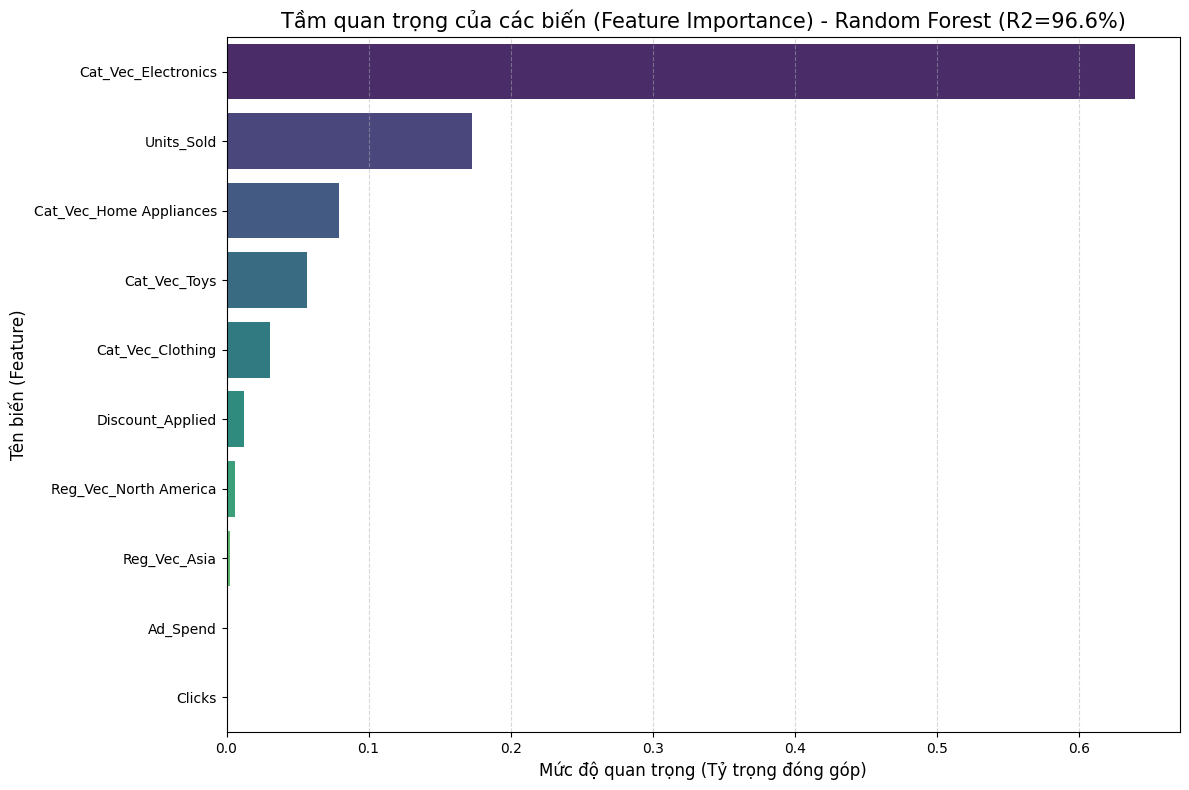

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
# Random Forest Importance luôn dương (tỷ trọng), nên dùng 1 dải màu
sns.barplot(x="Importance", y="Feature", data=df_rf_imp, palette="viridis")

plt.title("Tầm quan trọng của các biến (Feature Importance) - Random Forest (R2=96.6%)", fontsize=15)
plt.xlabel("Mức độ quan trọng (Tỷ trọng đóng góp)", fontsize=12)
plt.ylabel("Tên biến (Feature)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Đang thực hiện dự báo với Random Forest
--- Đang lấy mẫu 10% dữ liệu để vẽ biểu đồ Log Scale... ---


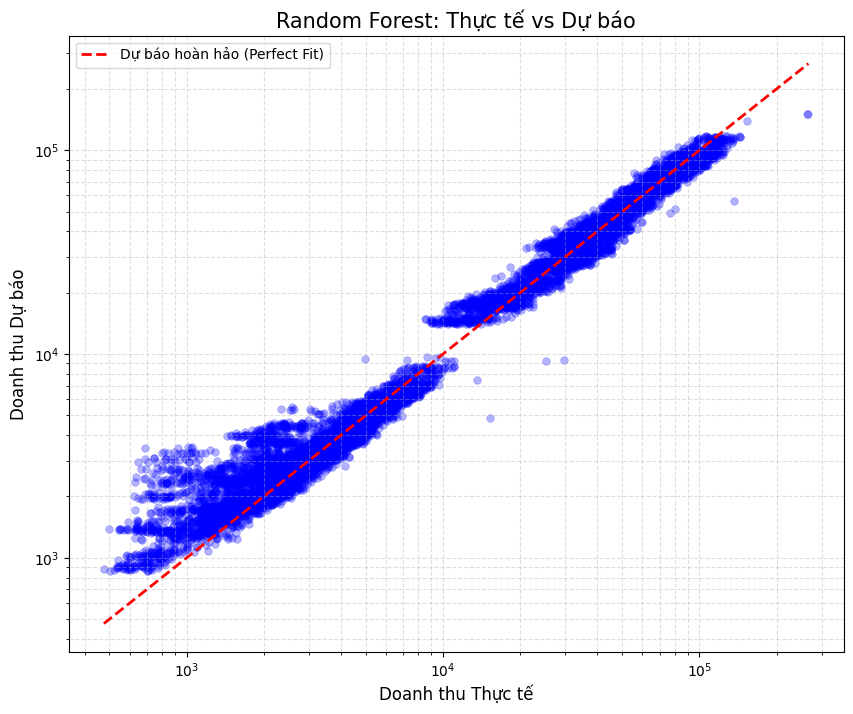

In [ ]:
# TRỰC QUAN HÓA: THỰC TẾ vs DỰ BÁO (RANDOM FOREST)
print("Đang thực hiện dự báo với Random Forest")
predictions_rf = final_rf_model.transform(df)

# Lấy mẫu dữ liệu (10%) để vẽ cho nhẹ và mượt
print("--- Đang lấy mẫu 10% dữ liệu để vẽ biểu đồ Log Scale... ---")
pdf_rf_sample = predictions_rf.select("Revenue", "prediction").sample(fraction=0.1, seed=42).toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))

# Vẽ các điểm dữ liệu
sns.scatterplot(x="Revenue", y="prediction", data=pdf_rf_sample,
                alpha=0.3, color='blue', s=30, edgecolor=None)

# Vẽ đường chéo chuẩn y=x
min_val = min(pdf_rf_sample["Revenue"].min(), pdf_rf_sample["prediction"].min())
max_val = max(pdf_rf_sample["Revenue"].max(), pdf_rf_sample["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Dự báo hoàn hảo (Perfect Fit)')

# Chuyển trục sang Logarithmic Scale
plt.xscale('log')
plt.yscale('log')

# Trang trí biểu đồ
plt.title("Random Forest: Thực tế vs Dự báo", fontsize=15)
plt.xlabel("Doanh thu Thực tế", fontsize=12)
plt.ylabel("Doanh thu Dự báo", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

plt.show()

Sau khi so sánh kết quả giữa **Linear Regression (LR)** và **Random Forest (RF)**, nhóm nghiên cứu nhận thấy sự thay đổi lớn về thứ hạng các biến quan trọng. Dưới đây là giải thích chi tiết:

**1. Giải mã sự khác biệt về Tầm quan trọng**

* **Tại Linear Regression (LR):** Mô hình dựa trên *phương trình đường thẳng*. Để giải thích được sự biến thiên khổng lồ của Doanh thu, nó buộc phải gán trọng số rất lớn cho **`Units_Sold`** (Sản lượng) và **`Discount`** (Giảm giá). Hệ số âm của Discount cho thấy tác động ngược chiều (càng giảm giá, doanh thu càng giảm).
* **Tại Random Forest (RF):** Mô hình dựa trên *cây quyết định (phân nhóm)*.
    * RF phát hiện ra quy luật cốt lõi: **"Loại sản phẩm (Category)" mới là yếu tố quyết định quy mô doanh thu.**
    * *Ví dụ:* Một đơn hàng thuộc nhóm **Electronics** (giá trị trung bình cao) dù có giảm giá hay không thì doanh thu vẫn cao hơn gấp nhiều lần so với nhóm **Clothing** hay **Books**.
    * Do đó, **`Cat_Vec_Electronics`** chiếm tới **~64%** tầm quan trọng, đẩy `Discount` xuống mức thấp (~1.2%).

**2. Làm rõ về biến Giảm giá (Discount)**

* **Lưu ý kỹ thuật:** Trong Random Forest, chỉ số *Feature Importance* **luôn dương** và đại diện cho mức độ đóng góp vào độ chính xác dự báo, **không đại diện cho chiều hướng (tăng/giảm)**.
* **Nhận định:** Việc `Discount` có điểm thấp (1.2%) trong RF không có nghĩa là nó làm tăng doanh thu. Nó có nghĩa là: *"Khi đã biết khách mua hàng gì (Category) và mua bao nhiêu (Units), thì thông tin về giảm giá không còn giúp cải thiện độ chính xác dự báo nhiều nữa"*.
* **Kết luận:** Kết hợp cả hai mô hình, ta thấy: Giảm giá tác động tiêu cực đến biên lợi nhuận (LR) và không phải là yếu tố then chốt để tạo ra doanh thu đột phá (RF).

**3. Kiến nghị**

Dựa trên mô hình tốt nhất Random Forest ($R^2 \approx 96.6\%$), doanh nghiệp cần tái định hướng:

1.  **Tái cấu trúc danh mục sản phẩm:**
    * Tập trung nguồn lực Marketing và hiển thị trang chủ cho nhóm **Electronics** và **Home Appliances** vì đây là các "Mỏ vàng" (Cash Cows) đóng góp hơn **70%** khả năng tạo ra doanh thu lớn.
2.  **Điều chỉnh chính sách giá:**
    * Hạn chế các chương trình giảm giá sâu đại trà cho các ngành hàng giá trị thấp (Books, Toys) vì không tạo ra đòn bẩy doanh thu hiệu quả.
3.  **Tối ưu hóa Quảng cáo (Ad Spend):**
    * Biến `Ad_Spend` có tầm quan trọng rất thấp trong cả 2 mô hình. Điều này báo động rằng ngân sách quảng cáo hiện tại đang bị lãng phí (chi tiền nhưng không ra doanh thu tương xứng). Cần rà soát lại kênh chạy quảng cáo (Google/Facebook/TikTok) để nhắm đúng đối tượng hơn.

In [ ]:
# Định nghĩa đường dẫn
rf_model_path = "models/random_forest_v1"

# Lưu mô hình
final_rf_model.write().overwrite().save(rf_model_path)

print(f"Đã lưu mô hình Random Forest thành công tại: {rf_model_path}")

Đã lưu mô hình Random Forest thành công tại: models/random_forest_v1


In [ ]:
import shutil
shutil.make_archive('random_forest_v1', 'zip', 'models/random_forest_v1')

'/content/random_forest_v1.zip'

--- Đang tính toán PDP cho biến Discount_Applied (từ 0.0 đến 0.3) ---


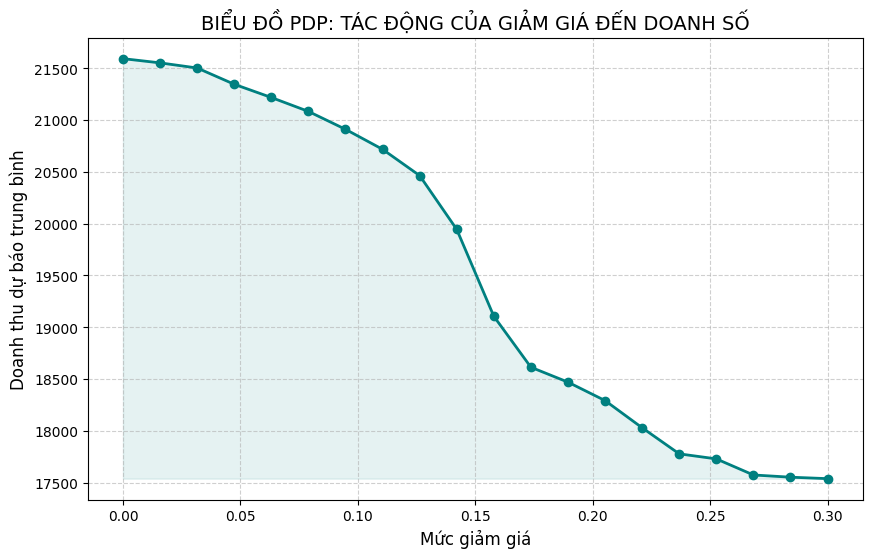

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# 1. Xác định phạm vi thực tế của biến Discount_Applied trong dữ liệu
stats = df.select(F.min("Discount_Applied"), F.max("Discount_Applied")).collect()[0]
min_discount = stats[0]
max_discount = stats[1]

# Tạo 20 điểm dữ liệu giả lập từ mức thấp nhất đến cao nhất
discount_range = np.linspace(min_discount, max_discount, 20)

# 2. Lấy một mẫu dữ liệu đại diện để tính toán nhanh (khoảng 500-1000 dòng)
# PDP yêu cầu chạy dự báo nhiều lần, nên dùng mẫu sẽ giúp tiết kiệm thời gian
sample_df = df.sample(False, 0.1, seed=42).limit(500).cache()

pdp_values = []

print(f"--- Đang tính toán PDP cho biến Discount_Applied (từ {min_discount} đến {max_discount}) ---")

for val in discount_range:
    # Gán mức giảm giá cố định 'val' cho toàn bộ tập mẫu
    test_df = sample_df.withColumn("Discount_Applied", F.lit(float(val)))

    # Sử dụng final_rf_model (đã huấn luyện ở Cell 65) để dự báo
    predictions = final_rf_model.transform(test_df)

    # Tính Doanh thu trung bình dự báo ở mức giảm giá này
    avg_pred = predictions.select(F.mean("prediction")).collect()[0][0]
    pdp_values.append(avg_pred)

# 3. Vẽ biểu đồ Partial Dependence Plot
plt.figure(figsize=(10, 6))
plt.plot(discount_range, pdp_values, marker='o', color='teal', linewidth=2)
plt.fill_between(discount_range, pdp_values, min(pdp_values), alpha=0.1, color='teal')

plt.title('BIỂU ĐỒ PDP: TÁC ĐỘNG CỦA GIẢM GIÁ ĐẾN DOANH SỐ', fontsize=14)
plt.xlabel('Mức giảm giá', fontsize=12)
plt.ylabel('Doanh thu dự báo trung bình', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Giải phóng bộ nhớ mẫu
sample_df.unpersist()
plt.show()

Sau khi xác định **Random Forest** là mô hình có hiệu suất tốt nhất, nhóm thực hiện phân tích **Partial Dependence Plot (PDP)**. Kỹ thuật này giúp cô lập ảnh hưởng của biến `Discount_Applied` lên `Revenue` (Doanh thu) bằng cách tính trung bình các dự báo của mô hình trên toàn bộ tập dữ liệu tại mỗi mức giảm giá cụ thể.

### Quan sát tổng quan

Biểu đồ PDP cho thấy một mối quan hệ **nghịch biến phi tuyến tính (non-linear inverse relationship)** rõ rệt giữa mức độ chiết khấu và doanh thu dự báo:

* **Xu hướng chủ đạo:** Khi mức giảm giá tăng từ 0% lên 30%, doanh thu dự báo trung bình có xu hướng giảm dần.
* **Biên độ tác động:** Doanh thu dao động từ mức đỉnh ~21,600 (tại mức discount 0%) xuống mức đáy ~17,600 (tại mức discount 30%).

### Các ngưỡng tác động quan trọng

Dựa trên độ dốc của đường biểu diễn, chúng ta có thể chia chiến lược giảm giá thành 3 giai đoạn tâm lý:

1. **Vùng Ổn định (0% - 7%):** * Đường biểu diễn dốc khá thoải. Việc áp dụng các mức giảm giá nhỏ (dưới 7%) không làm sụt giảm doanh thu quá mạnh. Điều này cho thấy khách hàng ở nhóm này có thể không quá nhạy cảm với giá, hoặc giá trị đơn hàng vẫn đủ cao để bù đắp mức chiết khấu.
2. **Vùng Rơi tự do (7% - 16%):** * Đây là vùng **nguy hiểm nhất**. Độ dốc tăng mạnh, đặc biệt là quanh mốc **10% - 15%**. Tại đây, mỗi 1% giảm giá thêm vào gây ra sự sụt giảm doanh thu lớn hơn so với các vùng khác.
* *Nhận định:* Có vẻ như việc tăng giảm giá trong khoảng này không kích cầu đủ mạnh để gia tăng số lượng đơn hàng (Volume) nhằm bù đắp cho sự sụt giảm về đơn giá (Price).


3. **Vùng Bão hòa (20% - 30%):** * Đà giảm bắt đầu chậm lại và có dấu hiệu đi ngang (plateau) khi tiến dần về mức 30%. Doanh thu chạm mức sàn và ít biến động thêm dù có tăng thêm mức chiết khấu.

### 5.3. Thông tin chi tiết dành cho cấp quản lý (Business Insights)

* **Hiệu ứng "Cannibalization" (Ăn mòn doanh thu):** Kết quả từ mô hình Random Forest cho thấy chiến lược giảm giá đại trà (Mass Discount) hiện tại có thể đang gây phản tác dụng về mặt tổng doanh thu. Thay vì thu hút khách hàng mới, chúng ta có thể đang vô tình giảm giá cho những khách hàng vốn dĩ sẵn sàng mua ở mức giá cao hơn.
* **Độ đàn hồi của cầu (Price Elasticity):** Trong bối cảnh dữ liệu này, nhu cầu không đủ đàn hồi để phản ứng tích cực với các mức giảm giá sâu. Việc giảm giá không tạo ra sự bùng nổ về số lượng đơn hàng đủ để tối ưu hóa doanh thu.

### Khuyến nghị

* **Tối ưu mức chiết khấu:** Nên ưu tiên các chương trình khuyến mãi trong khoảng **0% - 5%**. Đây là vùng "an toàn" nơi doanh thu được bảo toàn tốt nhất.
* **Tái cấu trúc chiến dịch >15%:** Cần xem xét lại các chương trình giảm giá sâu (trên 15%). Nếu mục tiêu là **Doanh thu**, các mức này hiện không hiệu quả. Tuy nhiên, nếu mục tiêu là **Xả kho** hoặc **Tăng thị phần (Market Share)**, cần chấp nhận mức sụt giảm doanh thu như biểu đồ đã dự báo.



# <font color='red'>**PHẦN KẾT: TỔNG KẾT VÀ HƯỚNG PHÁT TRIỂN**</font>

**1. Tổng kết Dự án**
Bài nghiên cứu đã hoàn thành việc xây dựng quy trình phân tích dữ liệu lớn trên nền tảng **Apache Spark** để đánh giá tác động của chiến lược giảm giá đến doanh số.
* **Về mặt kỹ thuật:** Đã xây dựng thành công pipeline xử lý dữ liệu và huấn luyện mô hình máy học phân tán. Mô hình **Random Forest Regressor** được lựa chọn là mô hình tối ưu với độ chính xác **$R^2 \approx 96.6\%$** và sai số RMSE thấp nhất.
* **Về mặt kinh doanh:** Kết quả định lượng đã bác bỏ giả thuyết *"Giảm giá càng sâu, doanh thu càng tăng"*. Thực tế cho thấy yếu tố quyết định doanh thu nằm ở việc **tối ưu hóa danh mục sản phẩm (Category Mix)**, đặc biệt là nhóm hàng Điện tử và Gia dụng, thay vì lạm dụng các chương trình giảm giá đại trà.

**2. Giá trị đóng góp**
* Cung cấp một công cụ dự báo doanh thu có độ tin cậy cao cho doanh nghiệp.
* Đưa ra các khuyến nghị chiến lược dựa trên dữ liệu (Data-driven) giúp doanh nghiệp tái phân bổ ngân sách Marketing hiệu quả hơn.

**3. Hạn chế và Hướng phát triển**
* **Hạn chế:** Dữ liệu hiện tại là dữ liệu giao dịch tĩnh, chưa bao gồm hành vi thời gian thực của khách hàng trên website.
* **Hướng phát triển:**
    * Tích hợp thêm dữ liệu **Clickstream** (luồng sự kiện click) để phân tích hành vi khách hàng chi tiết hơn.
    * Thử nghiệm mô hình **A/B Testing** trong thực tế để kiểm chứng hiệu quả của việc cắt giảm ngân sách khuyến mãi như mô hình đề xuất.
    * Xây dựng hệ thống **Recommender System** (Gợi ý sản phẩm) để tăng giá trị đơn hàng trung bình (AOV) thay vì dùng giảm giá.